In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

!pip install mlxtend==0.18.0

from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import distance

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


     |████████████████████████████████| 1.4MB 13.0MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2016-17-to-2018-19-immunizations.csv to 2016-17-to-2018-19-immunizations.csv


In [ ]:
#load dataset 
dataset = pd.read_csv('2016-17-to-2018-19-immunizations.csv',encoding = "ISO-8859-1")
dataset.head(20)

,SCHOOL_YEAR,SCHOOL_CODE,COUNTY,PUBLIC_PRIVATE,CITY,SCHOOL_NAME,REPORTED,ENROLLMENT,CATEGORY,COUNT,PERCENT
0,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,PBE,NaN,NaN
1,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,HEPB,NaN,NaN
2,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,DTP,NaN,NaN
3,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,POLIO,NaN,NaN
4,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,Up-To-Date,NaN,NaN
5,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,Others,NaN,NaN
6,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,VARI,NaN,NaN
7,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,Conditional,NaN,NaN
8,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,Overdue,NaN,NaN
9,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,PME,NaN,NaN


# Preprocessing

In [ ]:
dataset = dataset.drop_duplicates()

#Copy of original dataset
origDataset = dataset

#Drop duplicates
dataset = dataset.drop_duplicates()

#Dataset statistics
dataset.describe()

#Used backward fill for the attribute "ENROLLMENT"
dataset.ENROLLMENT = dataset.ENROLLMENT.fillna(method='bfill')

#Bacward fill and mean were disregarded for filling "COUNT" because they both introduced significant difference in statistics
#"COUNT" is filled by calculating the mean percentage of valid and non-zero samples. It is then scaled according to "ENROLLMENT"
validValues = len(dataset.PERCENT)- (dataset.PERCENT.isin([0]).sum() + dataset.PERCENT.isna().sum())
avgCount = dataset.PERCENT.sum() / validValues
enrollment = dataset.iloc[:,7:8]
vaccinated = dataset.iloc[:,9:10]
dataset.COUNT = round(dataset.ENROLLMENT * (avgCount / 100))
dataset.PERCENT = round((dataset.COUNT * 100) / dataset.ENROLLMENT)

#"PERCENTAGE" is redundant, dropping it
dataset = dataset.drop(['PERCENT'], axis = 1)
dataset_backup = dataset.copy()
dataset.head()

,SCHOOL_YEAR,SCHOOL_CODE,COUNTY,PUBLIC_PRIVATE,CITY,SCHOOL_NAME,REPORTED,ENROLLMENT,CATEGORY,COUNT
0,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,PBE,6.0
1,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,HEPB,6.0
2,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,DTP,6.0
3,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,POLIO,6.0
4,2016-2017,52749,MONTEREY,PRIVATE,PRUNEDALE,PRUNEDALE CHRISTIAN ACADEMY,Y,10.0,Up-To-Date,6.0


In [ ]:
#Dictionaries

year_dict = {"2016-2017" : "0", "2017-2018" : "1", "2018-2019" : "2"}
type_dict = {"PUBLIC" : "0", "PRIVATE" : "1"}
reported_dict = {"Y" : "0", "N" : "1"}
county_dict = {k: v for k,v in zip(dataset.COUNTY,list(range(1,len(dataset.COUNTY)+1)))}
city_dict = {k: v for k,v in zip(dataset.CITY,list(range(1,len(dataset.CITY)+1)))}
school_dict = {k: v for k,v in zip(dataset.SCHOOL_NAME,list(range(1,len(dataset.SCHOOL_NAME)+1)))}
category_dict = {k: v for k,v in zip(dataset.CATEGORY,list(range(1,len(dataset.CATEGORY)+1)))}

In [ ]:
#Numeric Encoding

dataset.SCHOOL_YEAR = dataset.iloc[:,0:1].replace(year_dict)
dataset.SCHOOL_YEAR = dataset.iloc[:,0:1].astype(int)

dataset.COUNTY = dataset.iloc[:,2:3].replace(county_dict)
dataset.COUNTY = dataset.iloc[:,2:3].astype(int)

dataset.PUBLIC_PRIVATE = dataset.iloc[:,3:4].replace(type_dict)
dataset.PUBLIC_PRIVATE = dataset.iloc[:,3:4].astype(int)

dataset.CITY = dataset.iloc[:,4:5].replace(city_dict)
dataset.CITY = dataset.iloc[:,4:5].astype(int)

dataset.SCHOOL_NAME = dataset.iloc[:,5:6].replace(school_dict)
dataset.SCHOOL_NAME = dataset.iloc[:,5:6].astype(int)

dataset.REPORTED = dataset.iloc[:,6:7].replace(reported_dict)
dataset.REPORTED = dataset.iloc[:,6:7].astype(int)

dataset.CATEGORY = dataset.iloc[:,8:9].replace(category_dict)
dataset.CATEGORY = dataset.iloc[:,8:9].astype(int)

nonNormalized = dataset.copy()
nonNormalized = nonNormalized[nonNormalized.REPORTED==0]

dataset.head()

,SCHOOL_YEAR,SCHOOL_CODE,COUNTY,PUBLIC_PRIVATE,CITY,SCHOOL_NAME,REPORTED,ENROLLMENT,CATEGORY,COUNT
0,0,52749,261411,1,90937,250161,0,10.0,181067,6.0
1,0,52749,261411,1,90937,250161,0,10.0,263070,6.0
2,0,52749,261411,1,90937,250161,0,10.0,263067,6.0
3,0,52749,261411,1,90937,250161,0,10.0,263068,6.0
4,0,52749,261411,1,90937,250161,0,10.0,90918,6.0


In [ ]:
#Normalize

dataframe = dataset.SCHOOL_CODE
dataset.SCHOOL_CODE = (dataframe - dataframe.mean())/dataframe.std()

dataframe = dataset.COUNTY
dataset.COUNTY = (dataframe - dataframe.mean())/dataframe.std()

dataframe = dataset.CITY
dataset.CITY = (dataframe - dataframe.mean())/dataframe.std()

dataframe = dataset.SCHOOL_NAME
dataset.SCHOOL_NAME = (dataframe - dataframe.mean())/dataframe.std()

dataframe = dataset.ENROLLMENT
dataset.ENROLLMENT = (dataframe - dataframe.mean())/dataframe.std()

dataframe = dataset.CATEGORY
dataset.CATEGORY = (dataframe - dataframe.mean())/dataframe.std()

dataframe = dataset.COUNT
dataset.COUNT = (dataframe - dataframe.mean())/dataframe.std()

dataset.head()

,SCHOOL_YEAR,SCHOOL_CODE,COUNTY,PUBLIC_PRIVATE,CITY,SCHOOL_NAME,REPORTED,ENROLLMENT,CATEGORY,COUNT
0,0,-2.55377,-0.282765,1,-9.315299,0.895125,0,-1.183378,-0.943227,-1.19488
1,0,-2.55377,-0.282765,1,-9.315299,0.895125,0,-1.183378,0.457169,-1.19488
2,0,-2.55377,-0.282765,1,-9.315299,0.895125,0,-1.183378,0.457118,-1.19488
3,0,-2.55377,-0.282765,1,-9.315299,0.895125,0,-1.183378,0.457135,-1.19488
4,0,-2.55377,-0.282765,1,-9.315299,0.895125,0,-1.183378,-2.482735,-1.19488


#calculation of summary stats

In [ ]:
dataset_backup.describe(include='float64')

,ENROLLMENT,COUNT
count,263071.000000,263071.000000
mean,69.328086,44.050340
std,50.134537,31.844487
min,1.000000,1.000000
25%,26.000000,17.000000
50%,68.000000,43.000000
75%,101.000000,64.000000
max,1117.000000,710.000000


In [ ]:
dataset_backup['SCHOOL_YEAR'].describe()

count        263071
unique            3
top       2016-2017
freq          90926
Name: SCHOOL_YEAR, dtype: object

In [ ]:
dataset_backup['SCHOOL_NAME'].describe()

count                 263071
unique                  8413
top       LINCOLN ELEMENTARY
freq                     993
Name: SCHOOL_NAME, dtype: object

In [ ]:
dataset_backup['COUNTY'].describe()

count          263071
unique             58
top       LOS ANGELES
freq            64043
Name: COUNTY, dtype: object

In [ ]:
dataset_backup['CITY'].describe()

count          263071
unique           1077
top       LOS ANGELES
freq            15549
Name: CITY, dtype: object

In [ ]:
dataset_backup['CATEGORY'].describe()

count     263071
unique        15
top          PME
freq       24661
Name: CATEGORY, dtype: object

In [ ]:
dataset_backup.groupby(["PUBLIC_PRIVATE"])[["ENROLLMENT"]].describe()

ENROLLMENT                                                      
                    count       mean        std  min   25%   50%    75%     max
PUBLIC_PRIVATE                                                                 
PRIVATE           68320.0  22.106982  19.000985  1.0   9.0  17.0   30.0   182.0
PUBLIC           194751.0  85.893577  47.030892  1.0  57.0  85.0  112.0  1117.0

In [ ]:
dataset_backup.groupby(["PUBLIC_PRIVATE"])[["COUNT"]].describe()

COUNT                                                    
                   count       mean        std  min   25%   50%   75%    max
PUBLIC_PRIVATE                                                              
PRIVATE          68320.0  14.069643  12.051408  1.0   6.0  11.0  19.0  116.0
PUBLIC          194751.0  54.567776  29.881904  1.0  36.0  54.0  71.0  710.0

In [ ]:
dataset_backup.groupby(["SCHOOL_YEAR"])[["ENROLLMENT"]].describe()

ENROLLMENT                                                      
                 count       mean        std  min   25%   50%    75%     max
SCHOOL_YEAR                                                                 
2016-2017      90926.0  69.820469  49.314376  1.0  26.0  68.0  102.0   732.0
2017-2018      90145.0  69.613545  51.352313  1.0  26.0  68.0  101.0  1117.0
2018-2019      82000.0  68.468293  49.669044  1.0  27.0  67.0   99.0   818.0

In [ ]:
dataset_backup.groupby(["SCHOOL_YEAR"])[["COUNT"]].describe()

COUNT                                                    
               count       mean        std  min   25%   50%   75%    max
SCHOOL_YEAR                                                             
2016-2017    90926.0  44.371280  31.316618  1.0  17.0  43.0  65.0  465.0
2017-2018    90145.0  44.227456  32.621038  1.0  17.0  43.0  64.0  710.0
2018-2019    82000.0  43.499756  31.552827  1.0  17.0  43.0  63.0  520.0

In [ ]:
dataset_backup.groupby(["SCHOOL_NAME"])[["REPORTED"]].describe()

REPORTED                
                                                  count unique top freq
SCHOOL_NAME                                                            
21ST CENTURY LEARNING INSTITUTE                      21      1   Y   21
A BETTER CHANCE / CALIFORNIA AUTISM FOUNDATION       11      1   N   11
A BIRDS EYE                                          10      1   N   10
A BRIGHT BEGINNING                                   32      2   Y   21
A BRIGHT BEGINNING CDC                               32      1   Y   32
...                                                 ...    ...  ..  ...
ZION LUTHERAN                                        54      1   Y   54
ZION LUTHERAN ELEMENTARY                             32      1   Y   32
ZION LUTHERAN SCHOOL                                 32      1   Y   32
ZION LUTHERAN SCHOOL AND PRESCHOOL                   32      1   Y   32
Zehnder Ranch Elementary                             11      1   Y   11

[8413 rows x 4 columns]

In [ ]:
dataset_backup.groupby(["COUNTY"])[["REPORTED"]].describe()

REPORTED                  
                   count unique top   freq
COUNTY                                    
ALAMEDA            10669      2   Y  10195
ALPINE                32      1   Y     32
AMADOR               245      2   Y    234
BUTTE               1855      1   Y   1855
CALAVERAS            438      2   Y    352
COLUSA               214      1   Y    214
CONTRA COSTA        7231      2   Y   7136
DEL NORTE            342      1   Y    342
EL DORADO           1384      1   Y   1384
FRESNO              7294      1   Y   7294
GLENN                427      1   Y    427
HUMBOLDT            1847      1   Y   1847
IMPERIAL            1463      1   Y   1463
INYO                 203      2   Y    192
KERN                6122      2   Y   5796
KINGS               1216      2   Y   1206
LAKE                 534      2   Y    523
LASSEN               439      2   Y    417
LOS ANGELES        64043      2   Y  58034
MADERA              1348      2   Y   1217
MARIN               2316      1   Y   2316
MARIPOSA             277      2   Y    189
MENDOCINO           1045      2   Y   1002
MERCED              2070      2   Y   1983
MODOC                149      1   Y    149
MONO                 192      1   Y    192
MONTEREY            3072      2   Y   3039
NAPA                1208      1   Y   1208
NEVADA               810      2   Y    799
ORANGE             19420      1   Y  19420
PLACER              3008      2   Y   2943
PLUMAS               278      2   Y    224
RIVERSIDE          12693      2   Y  12244
SACRAMENTO          9870      2   Y   9552
SAN BENITO           662      2   Y    642
SAN BERNARDINO     13737      2   Y  13696
SAN DIEGO          19864      2   Y  19842
SAN FRANCISCO       4779      2   Y   4757
SAN JOAQUIN         5911      1   Y   5911
SAN LUIS OBISPO     1972      2   Y   1940
SAN MATEO           5246      1   Y   5246
SANTA BARBARA       3315      2   Y   3272
SANTA CLARA        12443      2   Y  12355
SANTA CRUZ          2089      2   Y   2026
SHASTA              2114      2   Y   1975
SIERRA                75      1   Y     75
SISKIYOU             862      1   Y    862
SOLANO              2625      2   Y   2377
SONOMA              4172      2   Y   4120
STANISLAUS          4267      2   Y   3813
SUTTER              1099      2   Y   1088
TEHAMA               811      2   Y    779
TRINITY              299      2   Y    289
TULARE              3980      2   Y   3806
TUOLUMNE             555      1   Y    555
VENTURA             6126      2   Y   6049
YOLO                1472      1   Y   1472
YUBA                 842      2   Y    820

In [ ]:
dataset_backup.groupby(["CITY"])[["REPORTED"]].describe()

REPORTED                
                count unique top freq
CITY                                 
29 PALMS           10      1   Y   10
ACAMPO             64      1   Y   64
ACTON             149      2   Y  138
ACTON, CA          11      1   N   11
ADELANTO          320      1   Y  320
...               ...    ...  ..  ...
YREKA             117      1   Y  117
YUBA CITY         619      2   Y  608
YUCAIPA           288      1   Y  288
YUCCA VALLEY      180      2   Y  170
ZENIA              32      1   Y   32

[1077 rows x 4 columns]

In [ ]:
dataset_backup.groupby(["SCHOOL_YEAR"])[["REPORTED"]].describe()

REPORTED                  
               count unique top   freq
SCHOOL_YEAR                           
2016-2017      90926      2   Y  86020
2017-2018      90145      2   Y  87527
2018-2019      82000      2   Y  79640

In [ ]:
dataset_backup.groupby(["SCHOOL_NAME"])[["COUNT"]].describe()

COUNT              ...              
                                               count        mean  ...    75%    max
SCHOOL_NAME                                                       ...              
21ST CENTURY LEARNING INSTITUTE                 21.0    1.476190  ...    2.0    2.0
A BETTER CHANCE / CALIFORNIA AUTISM FOUNDATION  11.0   10.000000  ...   10.0   10.0
A BIRDS EYE                                     10.0    6.000000  ...    6.0    6.0
A BRIGHT BEGINNING                              32.0    9.906250  ...   13.0   13.0
A BRIGHT BEGINNING CDC                          32.0   10.312500  ...   11.0   11.0
...                                              ...         ...  ...    ...    ...
ZION LUTHERAN                                   54.0    2.796296  ...    3.0    5.0
ZION LUTHERAN ELEMENTARY                        32.0   10.125000  ...   14.0   14.0
ZION LUTHERAN SCHOOL                            32.0    9.406250  ...   11.0   11.0
ZION LUTHERAN SCHOOL AND PRESCHOOL              32.0    4.687500  ...    6.0    6.0
Zehnder Ranch Elementary                        11.0  136.000000  ...  136.0  136.0

[8413 rows x 8 columns]

In [ ]:
dataset_backup.groupby(["SCHOOL_NAME"])[["REPORTED"]].describe()

REPORTED                
                                                  count unique top freq
SCHOOL_NAME                                                            
21ST CENTURY LEARNING INSTITUTE                      21      1   Y   21
A BETTER CHANCE / CALIFORNIA AUTISM FOUNDATION       11      1   N   11
A BIRDS EYE                                          10      1   N   10
A BRIGHT BEGINNING                                   32      2   Y   21
A BRIGHT BEGINNING CDC                               32      1   Y   32
...                                                 ...    ...  ..  ...
ZION LUTHERAN                                        54      1   Y   54
ZION LUTHERAN ELEMENTARY                             32      1   Y   32
ZION LUTHERAN SCHOOL                                 32      1   Y   32
ZION LUTHERAN SCHOOL AND PRESCHOOL                   32      1   Y   32
Zehnder Ranch Elementary                             11      1   Y   11

[8413 rows x 4 columns]

In [ ]:
dataset_backup.groupby(["CATEGORY"])[["COUNT"]].describe()

COUNT                                                    
               count       mean        std  min   25%   50%   75%    max
CATEGORY                                                                
CONDITIONAL  16395.0  43.863495  32.094070  1.0  17.0  43.0  64.0  710.0
Conditional   8266.0  44.371280  31.318340  1.0  17.0  43.0  65.0  465.0
DTP          24661.0  44.033697  31.836430  1.0  17.0  43.0  64.0  710.0
HEPB         24661.0  44.033697  31.836430  1.0  17.0  43.0  64.0  710.0
MMR          24661.0  44.033697  31.836430  1.0  17.0  43.0  64.0  710.0
OTHERS       16395.0  43.863495  32.094070  1.0  17.0  43.0  64.0  710.0
OVERDUE      16395.0  43.863495  32.094070  1.0  17.0  43.0  64.0  710.0
Others        8266.0  44.371280  31.318340  1.0  17.0  43.0  65.0  465.0
Overdue       8266.0  44.371280  31.318340  1.0  17.0  43.0  65.0  465.0
PBE          16461.0  44.299678  31.973543  1.0  17.0  43.0  65.0  710.0
PME          24661.0  44.033697  31.836430  1.0  17.0  43.0  64.0  710.0
POLIO        24661.0  44.033697  31.836430  1.0  17.0  43.0  64.0  710.0
UP-TO-DATE   16395.0  43.863495  32.094070  1.0  17.0  43.0  64.0  710.0
Up-To-Date    8266.0  44.371280  31.318340  1.0  17.0  43.0  65.0  465.0
VARI         24661.0  44.033697  31.836430  1.0  17.0  43.0  64.0  710.0

#visualization of summary stats (box plots, bar graphs, pie charts)

Text(0, 0.5, 'Frequency')

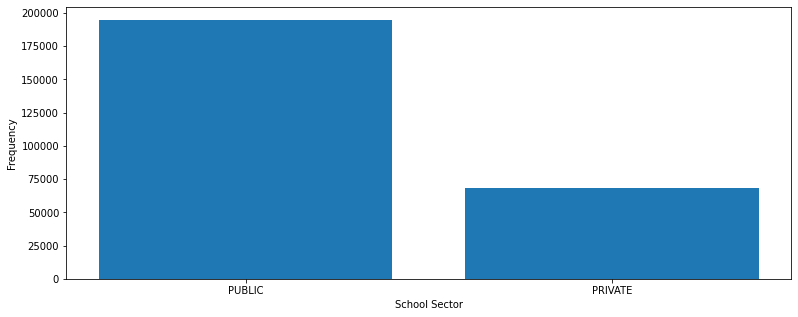

In [ ]:
ig, ax = plt.subplots(figsize=(13, 5)) 
data_count = dataset_backup['PUBLIC_PRIVATE'].value_counts() 
data = data_count.index 
frequency = data_count.values 
ax.bar(data, frequency) 
ax.set_xlabel('School Sector') 
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

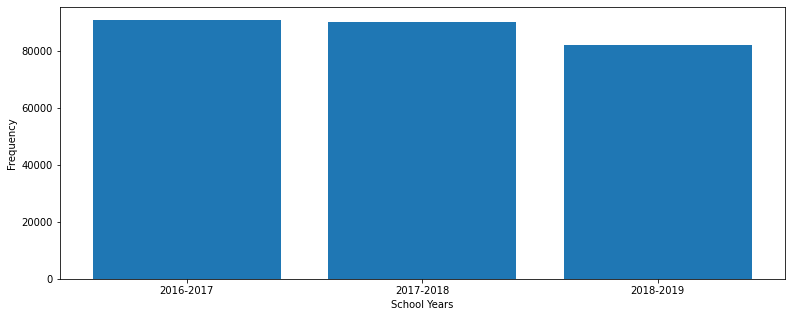

In [ ]:
ig, ax = plt.subplots(figsize=(13, 5)) 
data = dataset_backup['SCHOOL_YEAR'].value_counts() 
points = data.index 
frequency = data.values 
ax.bar(points, frequency) 
ax.set_xlabel('School Years') 
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

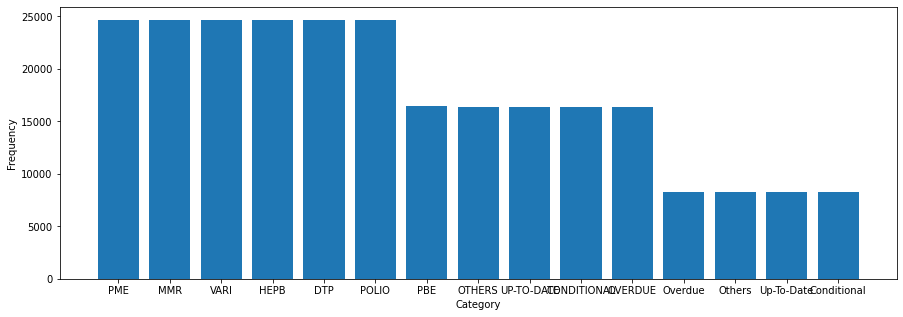

In [ ]:
ig, ax = plt.subplots(figsize=(15, 5)) 
data = dataset_backup['CATEGORY'].value_counts() 
points = data.index 
frequency = data.values 
ax.bar(points, frequency) 
ax.set_xlabel('Category') 
ax.set_ylabel('Frequency')

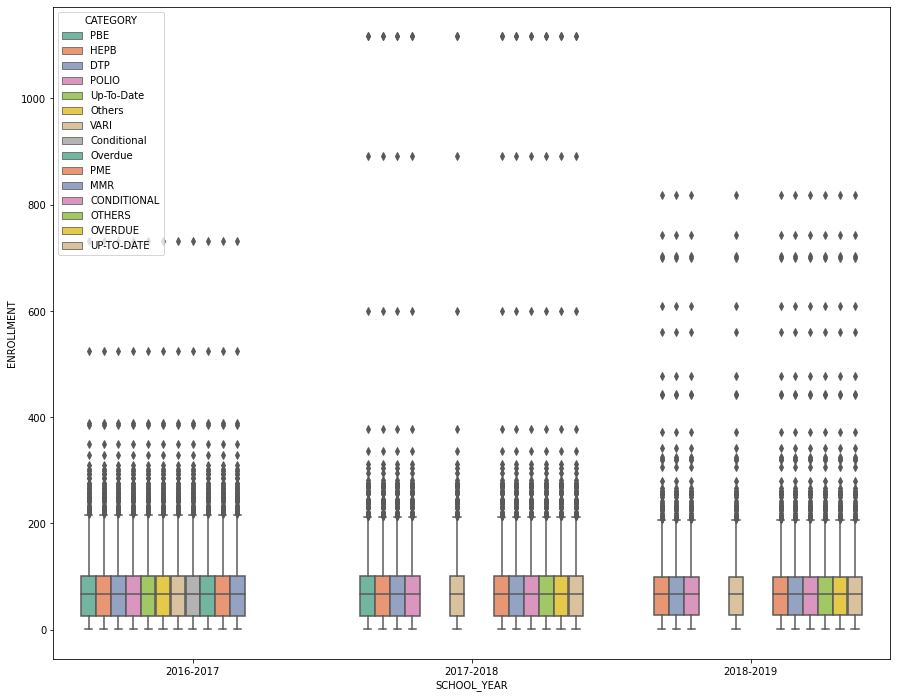

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.boxplot(x = "SCHOOL_YEAR", y = "ENROLLMENT", hue = "CATEGORY",data=dataset_backup, ax = ax, palette="Set2")

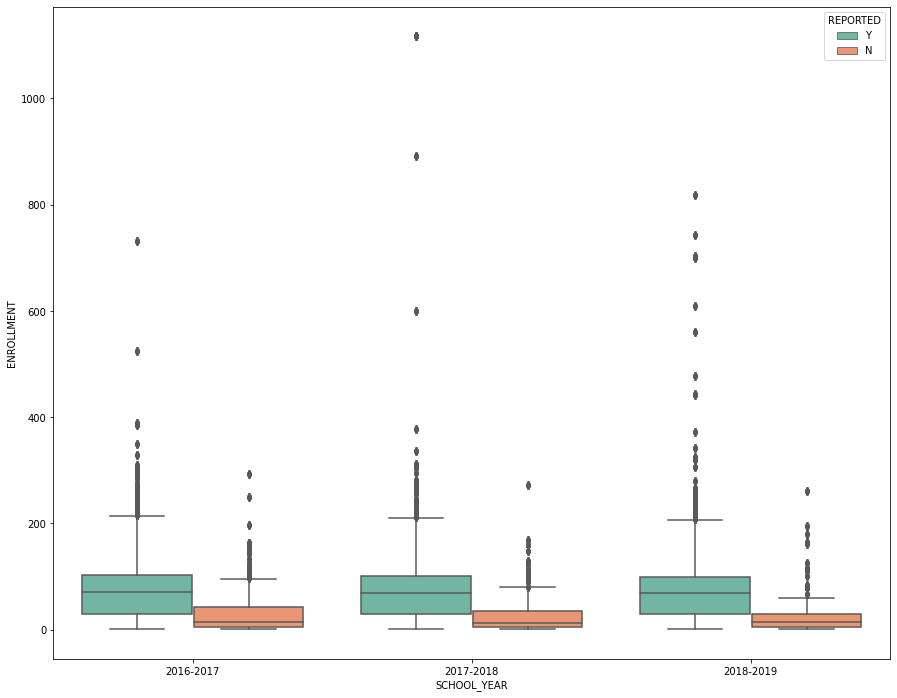

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.boxplot(x = "SCHOOL_YEAR", y = "ENROLLMENT", hue = "REPORTED",data=dataset_backup, ax = ax, palette="Set2")

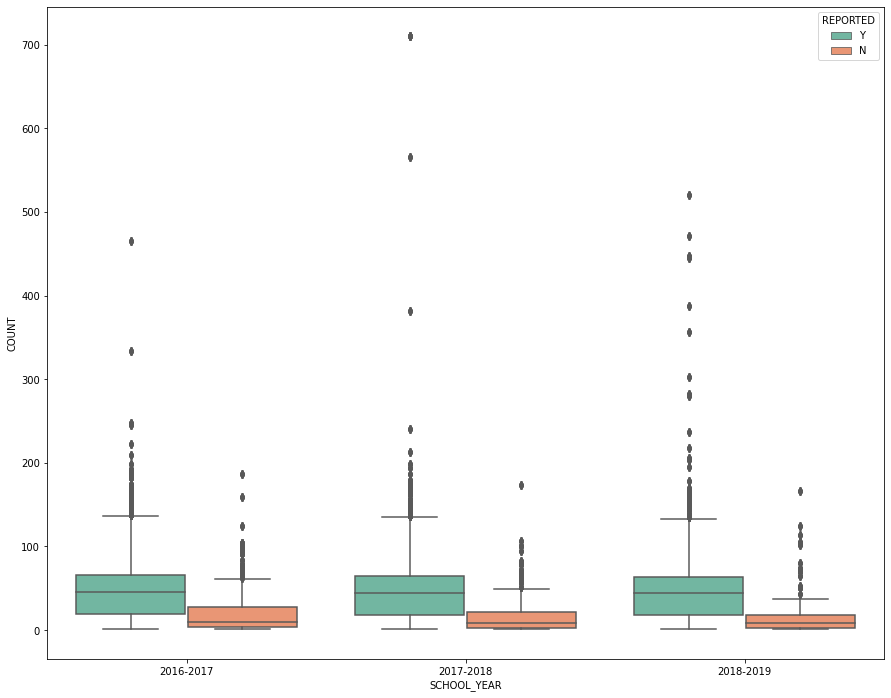

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.boxplot(x = "SCHOOL_YEAR", y = "COUNT", hue = "REPORTED",data=dataset_backup, ax = ax, palette="Set2")

#correlation(heatmaps)

In [ ]:
correlation = dataset_backup[['ENROLLMENT','COUNT']].corr()
correlation

,ENROLLMENT,COUNT
ENROLLMENT,1.000000,0.999959
COUNT,0.999959,1.000000


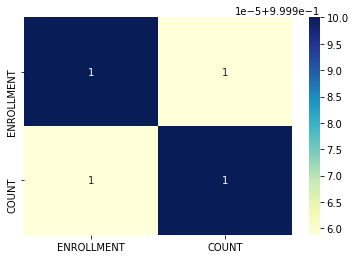

In [ ]:
ax = sns.heatmap(correlation, annot=True, cmap="YlGnBu")

In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_NAME'], dataset_backup['PUBLIC_PRIVATE']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 262768.0652470081
p                     : 0.0
dof                   : 8412


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_NAME'], dataset_backup['COUNT']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 20094819.299960285
p                     : 0.0
dof                   : 1724460


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_NAME'], dataset_backup['CATEGORY']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 8368.948753733022
p                     : 1.0
dof                   : 117768


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_NAME'], dataset_backup['COUNTY']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 13098064.071410557
p                     : 0.0
dof                   : 479484


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_NAME'], dataset_backup['CITY']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 250355871.07538489
p                     : 0.0
dof                   : 9051312


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_YEAR'], dataset_backup['CATEGORY']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 105218.02749220432
p                     : 0.0
dof                   : 28


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_YEAR'], dataset_backup['REPORTED']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 1031.6479876252026
p                     : 9.560615530813458e-225
dof                   : 2


In [ ]:
contigency_table = pd.crosstab(dataset_backup['SCHOOL_NAME'], dataset_backup['REPORTED']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 212132.94032084028
p                     : 0.0
dof                   : 8412


In [ ]:
contigency_table = pd.crosstab(dataset_backup['COUNTY'], dataset_backup['REPORTED']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 11973.905326208971
p                     : 0.0
dof                   : 57


In [ ]:
contigency_table = pd.crosstab(dataset_backup['COUNTY'], dataset_backup['COUNT']) 
from scipy.stats import chi2_contingency
chi, p, dof, expected = chi2_contingency(contigency_table) 
print("Chi square statics is :", chi)
print("p                     :", p)
print("dof                   :", dof)

Chi square statics is : 154740.0640649297
p                     : 0.0
dof                   : 11685


#### Comments on chi square test
A chi-square statistic is a measure of the difference between the observed and expected frequencies of the outcomes of a set of
 events. It determines whether there is an association between categorical variables. **p < 0.05** is the test for dependence.
So, value of p < 0.05, so there is strong association between school name and school sector, between school name and count(total number of enrollees vaccinated), between school name and reported(Immunization report was conductor or not), between school name and County, between school name and city, between school_year and category, between county and count, between county and reported. P values chi-square test between school name and category is 1, so there is no dependence between them.

#Dependance b/w numerical and categorical data



*   Categorical data= [SCHOOL_YEAR, SCHOOL_NAME, COUNTY, SCHOOL_SECTOR, CITY,REPORTED, CATEGORY]
*   Numeric data= [SCHOOL_CODE, ENROLLMENT, COUNT, PERCENTAGE]



[]

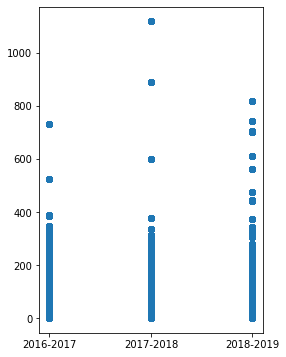

In [ ]:
#scatter plots 

#school year and enrollment  
   
plt.figure(figsize=(4,6))

plt.scatter(dataset_backup['SCHOOL_YEAR'], dataset_backup['ENROLLMENT'])
plt.plot()

[]

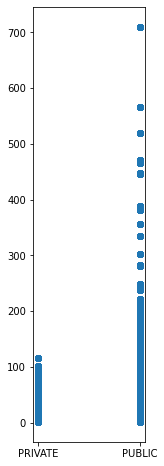

In [ ]:
#school sector and count
plt.figure(figsize=(2,8))

plt.scatter(dataset_backup['PUBLIC_PRIVATE'], dataset_backup['COUNT'])
plt.plot()

[]

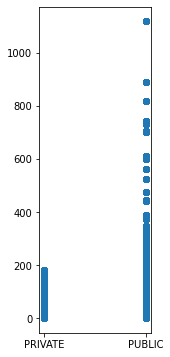

In [ ]:
# school sector and enrollment 
plt.figure(figsize=(2,6))

plt.scatter(dataset_backup['PUBLIC_PRIVATE'], dataset_backup['ENROLLMENT'])
plt.plot()

[]

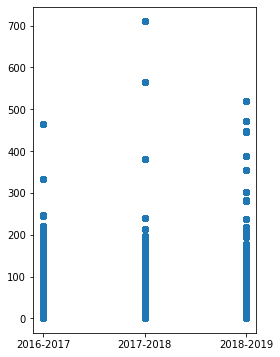

In [ ]:
#school year and count
plt.figure(figsize=(4,6))

plt.scatter(dataset_backup['SCHOOL_YEAR'], dataset_backup['COUNT'])
plt.plot()

[]

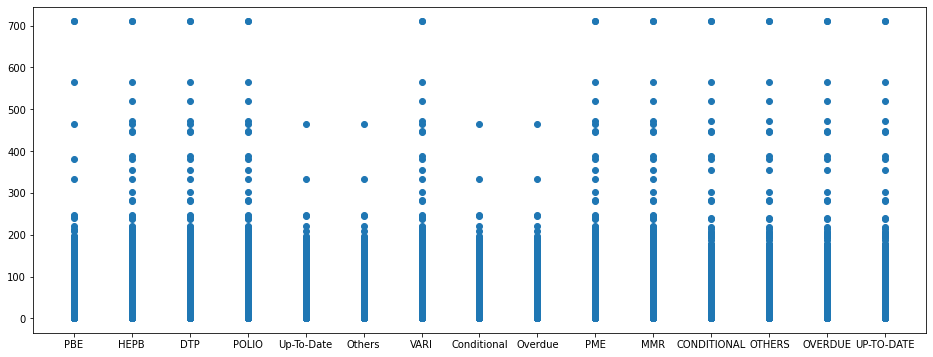

In [ ]:
#category and count
plt.figure(figsize=(16,6))
dataset_backup['CATEGORY'].astype('category')

dataset_backup.head()

plt.scatter(dataset_backup['CATEGORY'], dataset_backup['COUNT'])
plt.plot()

[]

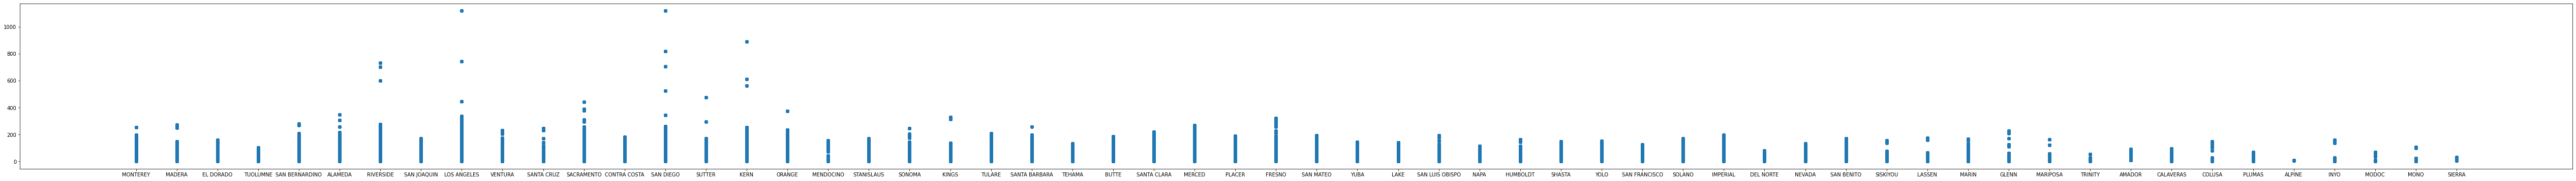

In [ ]:
# county and enrollment
plt.figure(figsize=(90,6))

plt.scatter(dataset_backup['COUNTY'], dataset_backup['ENROLLMENT'])
plt.plot()

[]

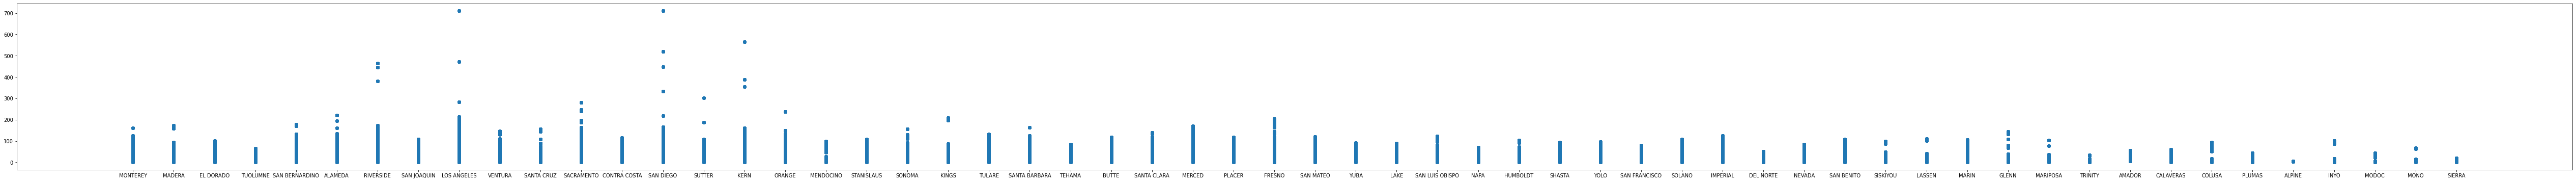

In [ ]:
#county and count 

plt.figure(figsize=(90,6))

plt.scatter(dataset_backup['COUNTY'], dataset_backup['COUNT'])
plt.plot()

In [ ]:
# pearson's correlation coefficient 
pearsoncorr = dataset.corr(method='pearson')

pearsoncorr

,SCHOOL_YEAR,SCHOOL_CODE,COUNTY,PUBLIC_PRIVATE,CITY,SCHOOL_NAME,REPORTED,ENROLLMENT,CATEGORY,COUNT
SCHOOL_YEAR,1.000000,-0.007853,0.000403,-0.009813,0.015274,0.168841,-0.054553,-0.010790,0.491299,-0.010953
SCHOOL_CODE,-0.007853,1.000000,0.010166,0.355456,0.105478,0.460633,0.037451,-0.187190,-0.004766,-0.187136
COUNTY,0.000403,0.010166,1.000000,0.072905,0.270041,0.024797,0.001419,0.103596,-0.000831,0.103533
PUBLIC_PRIVATE,-0.009813,0.355456,0.072905,1.000000,0.150733,0.288234,0.259733,-0.557871,-0.007146,-0.557625
CITY,0.015274,0.105478,0.270041,0.150733,1.000000,0.180585,-0.003884,0.054417,0.000185,0.054305
SCHOOL_NAME,0.168841,0.460633,0.024797,0.288234,0.180585,1.000000,-0.135481,-0.104208,0.077748,-0.104383
REPORTED,-0.054553,0.037451,0.001419,0.259733,-0.003884,-0.135481,1.000000,-0.160239,-0.033670,-0.160019
ENROLLMENT,-0.010790,-0.187190,0.103596,-0.557871,0.054417,-0.104208,-0.160239,1.000000,-0.004309,0.999959
CATEGORY,0.491299,-0.004766,-0.000831,-0.007146,0.000185,0.077748,-0.033670,-0.004309,1.000000,-0.004410
COUNT,-0.010953,-0.187136,0.103533,-0.557625,0.054305,-0.104383,-0.160019,0.999959,-0.004410,1.000000


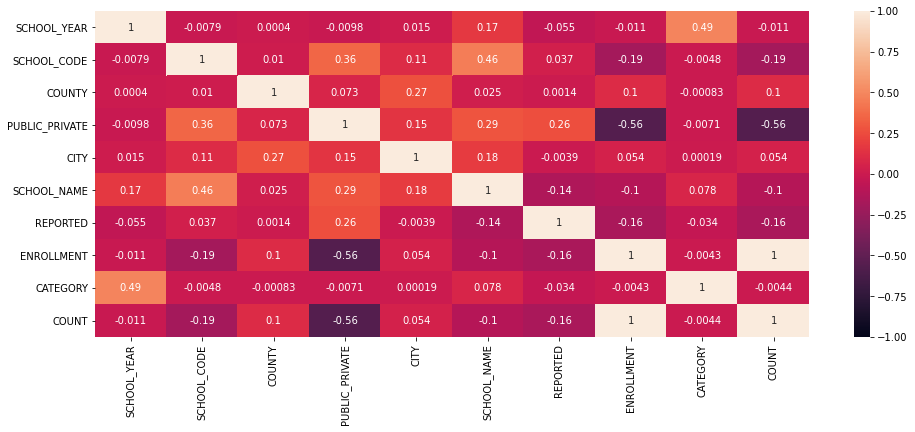

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(pearsoncorr, vmin=-1, vmax=1, annot=True)
heatmap

In [ ]:
#AUC FOR COUNT through Logistic Regression for school year, category and sector

dataset.head()
#turn count into discrete
dataset_backup.head()
dataset.dtypes['COUNT']
dataset['COUNT']=dataset['COUNT'].astype(int) 
#split the data to perform regression (count as y (dependant), categorical data as x)
x_axis=dataset[['SCHOOL_YEAR','PUBLIC_PRIVATE', 'CATEGORY']]
y_axis=dataset['COUNT']
#fit the model 
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.3)
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#predict probabilities 
probas = lr.predict_proba(X_test)
#get roc auc for count against all other attributes (one vs rest)
auc = roc_auc_score(y_test, probas, multi_class='ovr')
print('AUC of count: %.2f' % auc)

AUC of count: 0.72


In [ ]:
#AUC for enrollment  through Logistic Regression for school year, category and sector
dataset.head()
#turn count into discrete
dataset_backup.head()
dataset.dtypes['ENROLLMENT']
dataset['ENROLLMENT']=dataset['ENROLLMENT'].astype(int) 
#split the data to perform regression (enrolment as y (dependant), categorical data as x)
x_axis=dataset[['SCHOOL_YEAR','PUBLIC_PRIVATE', 'CATEGORY']]
y_axis=dataset['ENROLLMENT']
#fit the model 
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.3, stratify=y_axis)
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
#get roc auc for enrollment against all other attributes (one vs rest)
auc_enr = roc_auc_score(y_test, probs, multi_class='ovr')
print('AUC of enrollment: %.2f' % auc_enr)


AUC of enrollment: 0.71


In [ ]:
#AUC of enrollment for school year, county and category
x_axis=dataset[['SCHOOL_YEAR','COUNTY', 'CATEGORY']]
y_axis=dataset['ENROLLMENT']
#fit the model 
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.3)
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
#get roc auc for count  against all other attributes (one vs rest)
auc_enr = roc_auc_score(y_test, probs, multi_class='ovr')
print('AUC of enrollment: %.2f' % auc_enr)

AUC of enrollment: 0.67


In [ ]:
#AUC for count against sector, county and category
x_axis=dataset[['PUBLIC_PRIVATE','COUNTY', 'CATEGORY']]
y_axis=dataset['COUNT']
#fit the model 
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.3)
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
#get roc auc for count  against all other attributes (one vs rest)
auc_enr = roc_auc_score(y_test, probs, multi_class='ovr')
print('AUC of count: %.2f' % auc_enr)

AUC of count: 0.73


In [ ]:
# AUC for enrollment against county, sector and category 
x_axis=dataset[['PUBLIC_PRIVATE','COUNTY', 'CATEGORY']]
y_axis=dataset['ENROLLMENT']
#fit the model 
X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.3)
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
#get roc auc for count  against all other attributes (one vs rest)
auc_enr = roc_auc_score(y_test, probs, multi_class='ovr')
print('AUC of count: %.2f' % auc_enr)

AUC of count: 0.73


# annual immunizations by school sector

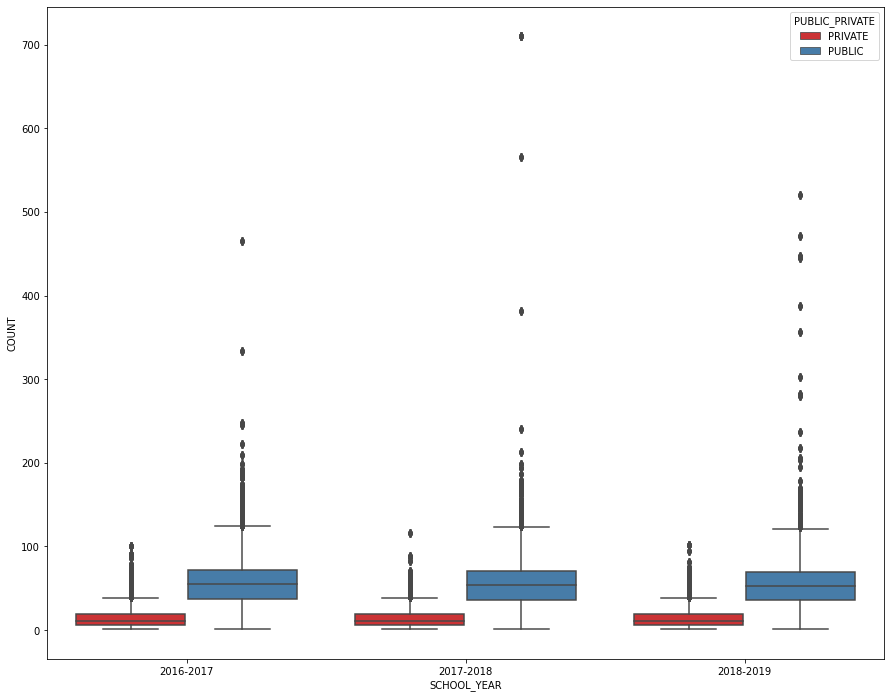

In [ ]:
#annual immunizations by school sector

fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.boxplot(x = "SCHOOL_YEAR", y = "COUNT", hue = "PUBLIC_PRIVATE",data=dataset_backup, ax = ax, palette="Set1")

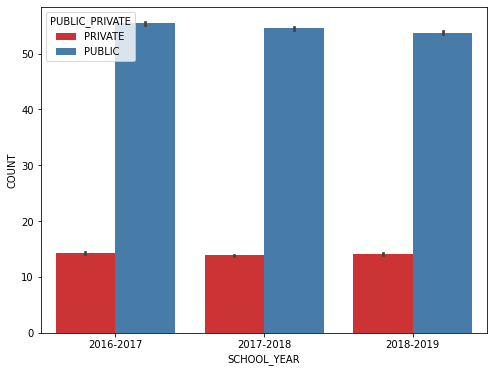

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.barplot(x = "SCHOOL_YEAR", y = "COUNT", hue = "PUBLIC_PRIVATE",data=dataset_backup, ax = ax, palette="Set1")

# Immunization category by percentage of immunization


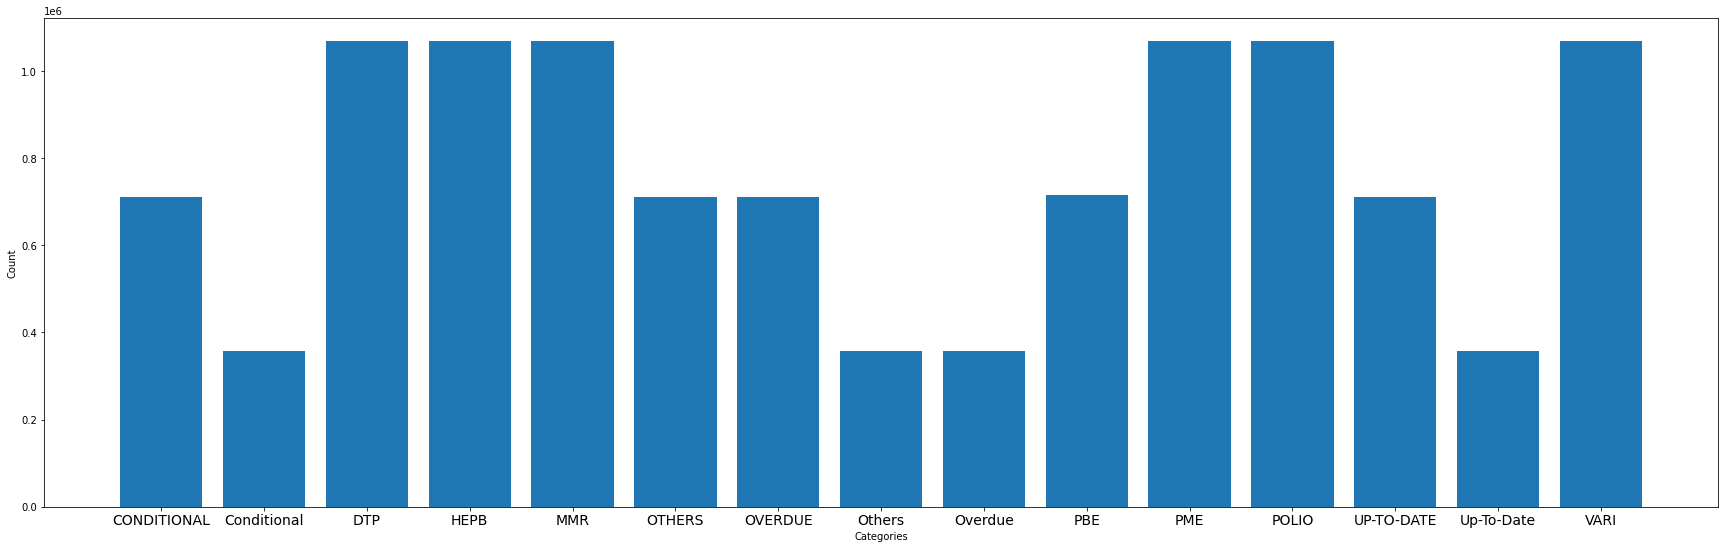

In [ ]:
#immunization by percentage 
imunizationconducted=dataset_backup[dataset_backup.REPORTED=='Y']
categorybysector = imunizationconducted[['COUNT','CATEGORY','ENROLLMENT']]
immunization_category=categorybysector.groupby(['CATEGORY']).sum().reset_index() 
immunization_category['PERCENT']=(immunization_category['COUNT']/immunization_category['ENROLLMENT'])*100
#PERCENTAGE IS REDUNDANT SO PLOTTING AGAINST COUNT 
y=immunization_category['COUNT'].tolist()
x=immunization_category['CATEGORY'].unique().tolist()
fig,ax=plt.subplots(figsize=(30,9))
plt.xticks(fontsize=14)
ax.bar(x,y)
ax.set(xlabel='Categories', ylabel='Count')
plt.show()


# immunization category by school sector 

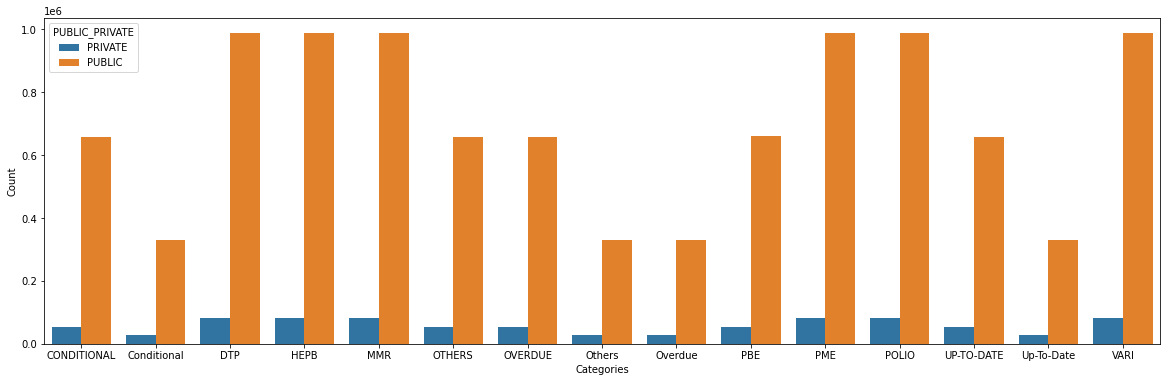

In [ ]:
#immunization category by school sector 
imunizationconducted=dataset_backup[dataset_backup.REPORTED=='Y']
categorybysector = imunizationconducted[['COUNT','CATEGORY','ENROLLMENT','PUBLIC_PRIVATE']]
immunization_category=categorybysector.groupby(['CATEGORY','PUBLIC_PRIVATE'])[('COUNT')].sum().reset_index() 
y=immunization_category['COUNT'].tolist()
x = immunization_category['CATEGORY'].tolist()
hue=immunization_category['PUBLIC_PRIVATE']
plt.figure(figsize=(20,6))
ax=sns.barplot(x=x,y=y,hue=hue,data=categorybysector )
ax.set(xlabel='Categories', ylabel='Count')
plt.show()

#Immunization category by school year 


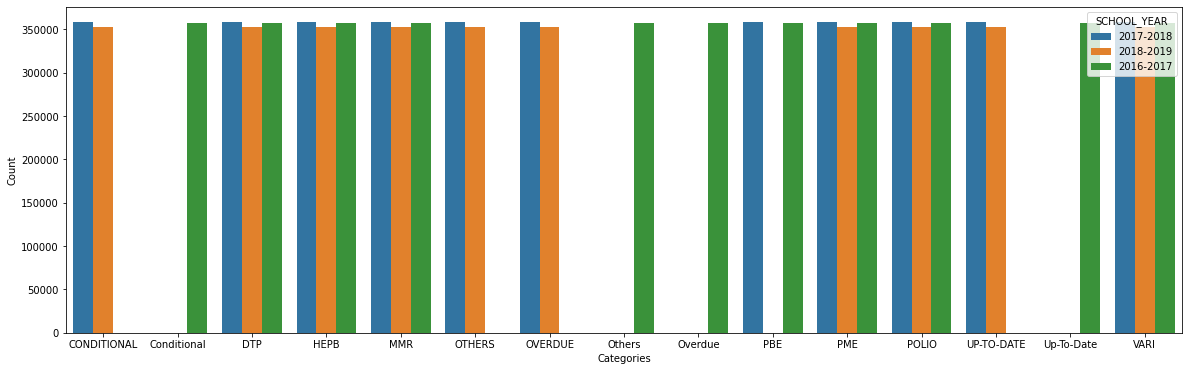

In [ ]:
imunizationconducted=dataset_backup[dataset_backup.REPORTED=='Y']
categorybysector = imunizationconducted[['COUNT','CATEGORY','ENROLLMENT','SCHOOL_YEAR']]
immunization_category=categorybysector.groupby(['CATEGORY','SCHOOL_YEAR'])[('COUNT')].sum().reset_index() 
y=immunization_category['COUNT'].tolist()
x = immunization_category['CATEGORY'].tolist()
hue=immunization_category['SCHOOL_YEAR']
plt.figure(figsize=(20,6))
ax=sns.barplot(x=x,y=y,hue=hue,data=categorybysector )
ax.set(xlabel='Categories', ylabel='Count')
plt.show()

#Immunization category by county

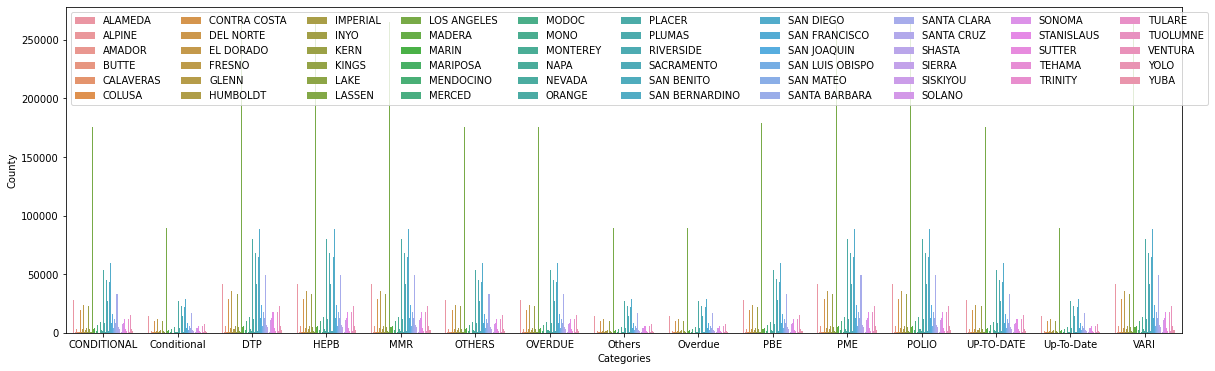

In [ ]:
imunizationconducted=dataset_backup[dataset_backup.REPORTED=='Y']
categorybysector = imunizationconducted[['COUNT','CATEGORY','ENROLLMENT','COUNTY']]
immunization_category=categorybysector.groupby(['CATEGORY','COUNTY'])[('COUNT')].sum().reset_index() 
y=immunization_category['COUNT'].tolist()
x = immunization_category['CATEGORY'].tolist()
hue=immunization_category['COUNTY']
plt.figure(figsize=(20,6))
ax=sns.barplot(x=x,y=y,hue=hue,data=categorybysector )
ax.set(xlabel='Categories', ylabel='County')
ax.legend(loc="upper left", ncol=len(dataset.columns))

plt.show()

# Frequent Pattern Mining


In [ ]:
def print_items(length, arr):
  f=arr.to_numpy()
  for item in f:
    if(len(item[1])>=length):
      print(item)

FPM for County and Category

In [ ]:
dframe=dataset_backup[dataset_backup.REPORTED=='Y']
df = dframe[['COUNTY','CATEGORY']]
fpm_df = df.values.tolist()
fpm = pd.Series(fpm_df)

In [ ]:
#For min support 0.1
multi_lbl_binarizer = MultiLabelBinarizer()
df = pd.DataFrame(multi_lbl_binarizer.fit_transform(fpm),
                   columns=multi_lbl_binarizer.classes_,
                   index=fpm.index)
start_time = time.time()

freq_items_fpgrowth = fpgrowth(df, min_support=0.1, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds \n" % (time.time() - start_time))

print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.0590226650238037 seconds 

    support       itemsets
0  0.220975  (LOS ANGELES)


In [ ]:
#For min support 0.05

start_time = time.time()

freq_items_fpgrowth = fpgrowth(df, min_support=0.05, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds \n" % (time.time() - start_time))

print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.270934820175171 seconds 

     support          itemsets
0   0.083119             (PBE)
1   0.091685            (HEPB)
2   0.091690             (DTP)
3   0.091685           (POLIO)
4   0.091685            (VARI)
5   0.091690             (PME)
6   0.091685             (MMR)
7   0.053611  (SAN BERNARDINO)
8   0.077086       (SAN DIEGO)
9   0.220975     (LOS ANGELES)
10  0.072229          (ORANGE)
11  0.050492     (CONDITIONAL)
12  0.050492          (OTHERS)
13  0.050492         (OVERDUE)
14  0.050492      (UP-TO-DATE)


In [ ]:
#For min support 0.02
start_time = time.time()

freq_items_fpgrowth = fpgrowth(df, min_support=0.02, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds \n" % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.346390724182129 seconds 

     support              itemsets
0   0.083119                 (PBE)
1   0.091685                (HEPB)
2   0.091690                 (DTP)
3   0.091685               (POLIO)
4   0.041198          (Up-To-Date)
5   0.041198              (Others)
6   0.091685                (VARI)
7   0.041198         (Conditional)
8   0.041198             (Overdue)
9   0.091690                 (PME)
10  0.091685                 (MMR)
11  0.053611      (SAN BERNARDINO)
12  0.045176             (ALAMEDA)
13  0.048437           (RIVERSIDE)
14  0.024029         (SAN JOAQUIN)
15  0.022701             (VENTURA)
16  0.037047          (SACRAMENTO)
17  0.032853        (CONTRA COSTA)
18  0.077086           (SAN DIEGO)
19  0.220975         (LOS ANGELES)
20  0.022875                (KERN)
21  0.072229              (ORANGE)
22  0.046651         (SANTA CLARA)
23  0.034423              (FRESNO)
24  0.050492         (CONDITIONAL)
25  0.050492              (OTHE

In [ ]:
#freq_items_fpgrowth = fpgrowth(df, min_support=0.02, use_colnames=True, max_len=None, verbose=0)
print_items(2,freq_items_fpgrowth)

[0.02019355892378288 frozenset({'HEPB', 'LOS ANGELES'})]
[0.02019355892378288 frozenset({'DTP', 'LOS ANGELES'})]
[0.02019355892378288 frozenset({'POLIO', 'LOS ANGELES'})]
[0.02019355892378288 frozenset({'LOS ANGELES', 'VARI'})]
[0.02019355892378288 frozenset({'LOS ANGELES', 'PME'})]
[0.02019355892378288 frozenset({'LOS ANGELES', 'MMR'})]


For FPM of Category and Sector 

In [ ]:
df =dframe[['CATEGORY','PUBLIC_PRIVATE']]
fpm = df.values.tolist()

In [ ]:
# for min support --0.1
df_fpm = pd.Series(fpm)
multi_lbl_binarizer = MultiLabelBinarizer()
val = pd.DataFrame(multi_lbl_binarizer.fit_transform(df_fpm),
                   columns=multi_lbl_binarizer.classes_,
                   index=df_fpm.index)
start_time = time.time()
freq_items_fpgrowth = fpgrowth(val, min_support=0.1, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.138700008392334 seconds 
    support   itemsets
0  0.217245  (PRIVATE)
1  0.782755   (PUBLIC)


In [ ]:
# for min support==0.05 
start_time = time.time()
freq_items_fpgrowth = fpgrowth(val, min_support=0.05, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.209456205368042 seconds 
     support         itemsets
0   0.217245        (PRIVATE)
1   0.083119            (PBE)
2   0.091685           (HEPB)
3   0.091690            (DTP)
4   0.091685          (POLIO)
5   0.091685           (VARI)
6   0.091690            (PME)
7   0.091685            (MMR)
8   0.782755         (PUBLIC)
9   0.050492    (CONDITIONAL)
10  0.050492         (OTHERS)
11  0.050492        (OVERDUE)
12  0.050492     (UP-TO-DATE)
13  0.063436    (PBE, PUBLIC)
14  0.071929   (HEPB, PUBLIC)
15  0.071934    (DTP, PUBLIC)
16  0.071929  (POLIO, PUBLIC)
17  0.071929   (VARI, PUBLIC)
18  0.071934    (PUBLIC, PME)
19  0.071929    (PUBLIC, MMR)


In [ ]:
print_items(2,freq_items_fpgrowth)

[0.06343611870630568 frozenset({'PBE', 'PUBLIC'})]
[0.07192868770842882 frozenset({'HEPB', 'PUBLIC'})]
[0.07193395605148224 frozenset({'DTP', 'PUBLIC'})]
[0.07192868770842882 frozenset({'POLIO', 'PUBLIC'})]
[0.07192868770842882 frozenset({'VARI', 'PUBLIC'})]
[0.07193395605148224 frozenset({'PUBLIC', 'PME'})]
[0.07192868770842882 frozenset({'PUBLIC', 'MMR'})]


In [ ]:
# for min support==0.02
start_time = time.time()
freq_items_fpgrowth = fpgrowth(val, min_support=0.02, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.2604234218597412 seconds 
     support               itemsets
0   0.217245              (PRIVATE)
1   0.083119                  (PBE)
2   0.091685                 (HEPB)
3   0.091690                  (DTP)
4   0.091685                (POLIO)
5   0.041198           (Up-To-Date)
6   0.041198               (Others)
7   0.091685                 (VARI)
8   0.041198          (Conditional)
9   0.041198              (Overdue)
10  0.091690                  (PME)
11  0.091685                  (MMR)
12  0.782755               (PUBLIC)
13  0.050492          (CONDITIONAL)
14  0.050492               (OTHERS)
15  0.050492              (OVERDUE)
16  0.050492           (UP-TO-DATE)
17  0.063436          (PBE, PUBLIC)
18  0.071929         (HEPB, PUBLIC)
19  0.071934          (DTP, PUBLIC)
20  0.071929        (POLIO, PUBLIC)
21  0.031436   (Up-To-Date, PUBLIC)
22  0.031436       (Others, PUBLIC)
23  0.071929         (VARI, PUBLIC)
24  0.031436  (PUBLIC, Conditional)
25  0

In [ ]:
print_items(2,freq_items_fpgrowth)

[0.06343611870630568 frozenset({'PBE', 'PUBLIC'})]
[0.07192868770842882 frozenset({'HEPB', 'PUBLIC'})]
[0.07193395605148224 frozenset({'DTP', 'PUBLIC'})]
[0.07192868770842882 frozenset({'POLIO', 'PUBLIC'})]
[0.031436202999794535 frozenset({'Up-To-Date', 'PUBLIC'})]
[0.031436202999794535 frozenset({'Others', 'PUBLIC'})]
[0.07192868770842882 frozenset({'VARI', 'PUBLIC'})]
[0.031436202999794535 frozenset({'PUBLIC', 'Conditional'})]
[0.031436202999794535 frozenset({'Overdue', 'PUBLIC'})]
[0.07193395605148224 frozenset({'PUBLIC', 'PME'})]
[0.07192868770842882 frozenset({'PUBLIC', 'MMR'})]
[0.040497753051687714 frozenset({'CONDITIONAL', 'PUBLIC'})]
[0.040497753051687714 frozenset({'OTHERS', 'PUBLIC'})]
[0.040497753051687714 frozenset({'OVERDUE', 'PUBLIC'})]
[0.040497753051687714 frozenset({'PUBLIC', 'UP-TO-DATE'})]


For FPM of sector, category and county

In [ ]:
df=dataset_backup[dataset_backup.REPORTED=='Y']
k= df[['CATEGORY','PUBLIC_PRIVATE','COUNTY']]
fpm = k.values.tolist()

In [ ]:
#for min support -- 0.1
t = pd.Series(fpm)
multi_lbl_binarizer = MultiLabelBinarizer()
fp_df= pd.DataFrame(multi_lbl_binarizer.fit_transform(t),
                   columns=multi_lbl_binarizer.classes_,
                   index=t.index)
start_time = time.time()
freq_items_fpgrowth = fpgrowth(fp_df, min_support=0.1, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.2922918796539307 seconds 
    support               itemsets
0  0.217245              (PRIVATE)
1  0.782755               (PUBLIC)
2  0.220975          (LOS ANGELES)
3  0.162571  (LOS ANGELES, PUBLIC)


In [ ]:
# for min support 0.05

start_time = time.time()
freq_items_fpgrowth = fpgrowth(fp_df, min_support=0.05, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.4330601692199707 seconds 
     support                itemsets
0   0.217245               (PRIVATE)
1   0.083119                   (PBE)
2   0.091685                  (HEPB)
3   0.091690                   (DTP)
4   0.091685                 (POLIO)
5   0.091685                  (VARI)
6   0.091690                   (PME)
7   0.091685                   (MMR)
8   0.782755                (PUBLIC)
9   0.053611        (SAN BERNARDINO)
10  0.077086             (SAN DIEGO)
11  0.220975           (LOS ANGELES)
12  0.072229                (ORANGE)
13  0.050492           (CONDITIONAL)
14  0.050492                (OTHERS)
15  0.050492               (OVERDUE)
16  0.050492            (UP-TO-DATE)
17  0.058405  (PRIVATE, LOS ANGELES)
18  0.063436           (PBE, PUBLIC)
19  0.071929          (HEPB, PUBLIC)
20  0.071934           (DTP, PUBLIC)
21  0.071929         (POLIO, PUBLIC)
22  0.071929          (VARI, PUBLIC)
23  0.071934           (PUBLIC, PME)
24  0.071929    

In [ ]:
print_items(2, freq_items_fpgrowth)

[0.058404851090283594 frozenset({'PRIVATE', 'LOS ANGELES'})]
[0.06343611870630568 frozenset({'PBE', 'PUBLIC'})]
[0.07192868770842882 frozenset({'HEPB', 'PUBLIC'})]
[0.07193395605148224 frozenset({'DTP', 'PUBLIC'})]
[0.07192868770842882 frozenset({'POLIO', 'PUBLIC'})]
[0.07192868770842882 frozenset({'VARI', 'PUBLIC'})]
[0.07193395605148224 frozenset({'PUBLIC', 'PME'})]
[0.07192868770842882 frozenset({'PUBLIC', 'MMR'})]
[0.06057014008524179 frozenset({'SAN DIEGO', 'PUBLIC'})]
[0.16257052994262775 frozenset({'LOS ANGELES', 'PUBLIC'})]


In [ ]:
# for min support 0.02 
start_time = time.time()
freq_items_fpgrowth = fpgrowth(fp_df, min_support=0.02, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print(freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.5539767742156982 seconds 
     support               itemsets
0   0.217245              (PRIVATE)
1   0.083119                  (PBE)
2   0.091685                 (HEPB)
3   0.091690                  (DTP)
4   0.091685                (POLIO)
..       ...                    ...
60  0.031584       (PUBLIC, FRESNO)
61  0.040498  (CONDITIONAL, PUBLIC)
62  0.040498       (OTHERS, PUBLIC)
63  0.040498      (OVERDUE, PUBLIC)
64  0.040498   (PUBLIC, UP-TO-DATE)

[65 rows x 2 columns]


In [ ]:
print_items(2, freq_items_fpgrowth)

[0.058404851090283594 frozenset({'PRIVATE', 'LOS ANGELES'})]
[0.06343611870630568 frozenset({'PBE', 'PUBLIC'})]
[0.07192868770842882 frozenset({'HEPB', 'PUBLIC'})]
[0.02019355892378288 frozenset({'HEPB', 'LOS ANGELES'})]
[0.07193395605148224 frozenset({'DTP', 'PUBLIC'})]
[0.02019355892378288 frozenset({'DTP', 'LOS ANGELES'})]
[0.07192868770842882 frozenset({'POLIO', 'PUBLIC'})]
[0.02019355892378288 frozenset({'POLIO', 'LOS ANGELES'})]
[0.031436202999794535 frozenset({'Up-To-Date', 'PUBLIC'})]
[0.031436202999794535 frozenset({'Others', 'PUBLIC'})]
[0.07192868770842882 frozenset({'VARI', 'PUBLIC'})]
[0.02019355892378288 frozenset({'LOS ANGELES', 'VARI'})]
[0.031436202999794535 frozenset({'PUBLIC', 'Conditional'})]
[0.031436202999794535 frozenset({'Overdue', 'PUBLIC'})]
[0.07193395605148224 frozenset({'PUBLIC', 'PME'})]
[0.02019355892378288 frozenset({'LOS ANGELES', 'PME'})]
[0.07192868770842882 frozenset({'PUBLIC', 'MMR'})]
[0.02019355892378288 frozenset({'LOS ANGELES', 'MMR'})]
[0.04452

For FPM of Category by school year, city and sector 

In [ ]:
df=dataset_backup[dataset_backup.REPORTED=='Y']
k= df[['CATEGORY','PUBLIC_PRIVATE','COUNTY', 'SCHOOL_YEAR']]
fpm = k.values.tolist()

In [ ]:
t = pd.Series(fpm)
multi_lbl_binarizer = MultiLabelBinarizer()
fp_df= pd.DataFrame(multi_lbl_binarizer.fit_transform(t),
                   columns=multi_lbl_binarizer.classes_,
                   index=t.index)
start_time = time.time()
freq_items_fpgrowth = fpgrowth(fp_df, min_support=0.05, use_colnames=True, max_len=None, verbose=0)
print("Time elapsed to run FPGrowth : %s seconds " % (time.time() - start_time))
print_items(2,freq_items_fpgrowth)

Time elapsed to run FPGrowth : 1.6229517459869385 seconds 
[0.3457982329977399 frozenset({'2016-2017', 'PUBLIC'})]
[0.1073846364579876 frozenset({'2016-2017', 'PRIVATE'})]
[0.058404851090283594 frozenset({'PRIVATE', 'LOS ANGELES'})]
[0.10912318966561826 frozenset({'PRIVATE', '2017-2018'})]
[0.06343611870630568 frozenset({'PBE', 'PUBLIC'})]
[0.07192868770842882 frozenset({'HEPB', 'PUBLIC'})]
[0.07193395605148224 frozenset({'DTP', 'PUBLIC'})]
[0.07192868770842882 frozenset({'POLIO', 'PUBLIC'})]
[0.07192868770842882 frozenset({'VARI', 'PUBLIC'})]
[0.07193395605148224 frozenset({'PUBLIC', 'PME'})]
[0.07192868770842882 frozenset({'PUBLIC', 'MMR'})]
[0.06057014008524179 frozenset({'SAN DIEGO', 'PUBLIC'})]
[0.16257052994262775 frozenset({'LOS ANGELES', 'PUBLIC'})]
[0.10274849457097249 frozenset({'2016-2017', 'LOS ANGELES'})]
[0.10668921517493533 frozenset({'2017-2018', 'LOS ANGELES'})]
[0.07452598083376798 frozenset({'2016-2017', 'LOS ANGELES', 'PUBLIC'})]
[0.07661224468292477 frozenset({'201

# Clustering


In [ ]:
subset_size = 20000

In [ ]:
def plotKElbowGraph(X):
    # k means determine k
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [ ]:
def plotClusters(denFact, att1, att2, labels):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    area = np.pi * ( X[:, 1])**denFact
    plt.scatter(X[:, 0], X[:, 1], s=area, c=labels.astype(np.float), alpha=0.5)
    plt.xlabel(att1, fontsize=18)
    plt.ylabel(att2, fontsize=16)

    plt.show()

**K-Means Clustering**

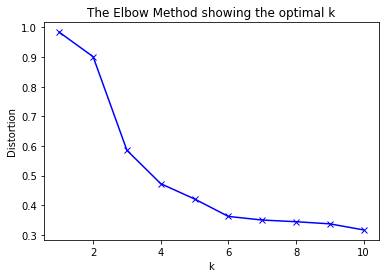

In [ ]:
attribute1 = 'COUNTY'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

scaler = StandardScaler()
normalized_dataset = scaler.fit_transform(subset)

X = normalized_dataset # Normalized numpy array, used later in the visualization step

# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
for i in range(3, 10):
    model = KMeans(n_clusters=i, n_init=12)
    kmeans = model.fit(X)
    cluster_labels = kmeans.fit_predict(X)
    s = silhouette_score(X, cluster_labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.5041
With  4 clusters, Silhoutte coefficient is  0.4612
With  5 clusters, Silhoutte coefficient is  0.4955
With  6 clusters, Silhoutte coefficient is  0.4953
With  7 clusters, Silhoutte coefficient is  0.4978
With  8 clusters, Silhoutte coefficient is  0.4764
With  9 clusters, Silhoutte coefficient is  0.4869


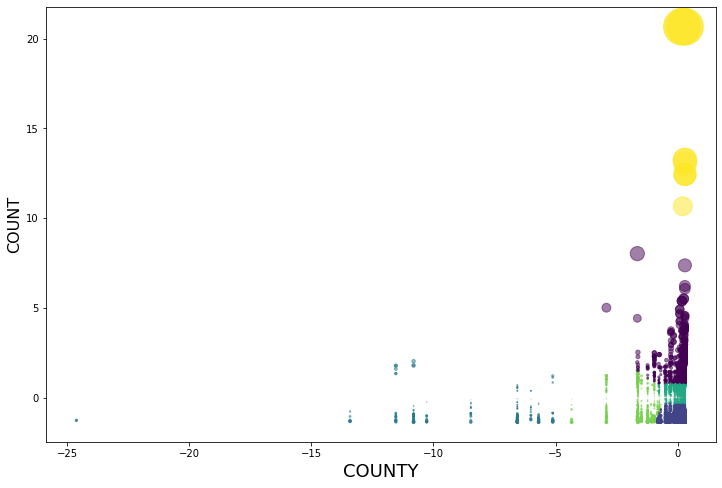

In [ ]:
model = KMeans(n_clusters=6, n_init=12)
kmeans = model.fit(X)
cluster_labels = kmeans.fit_predict(X)
labels = kmeans.labels_

plotClusters(2, attribute1, attribute2, labels)

**Agglomerative Clustering**

In [ ]:
attribute1 = 'COUNTY'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
X = subset
subset.head()

,COUNTY,COUNT
175671,263051,10.0
54103,263051,67.0
78597,263051,18.0
10389,262241,4.0
228227,262521,34.0


In [ ]:
for i in range(3, 9):
    clustering = AgglomerativeClustering(n_clusters = i).fit(X)
    labels = clustering.labels_
    s = silhouette_score(X, labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.8209
With  4 clusters, Silhoutte coefficient is  0.8225
With  5 clusters, Silhoutte coefficient is  0.7985
With  6 clusters, Silhoutte coefficient is  0.799
With  7 clusters, Silhoutte coefficient is  0.7357
With  8 clusters, Silhoutte coefficient is  0.7406


Dendogram

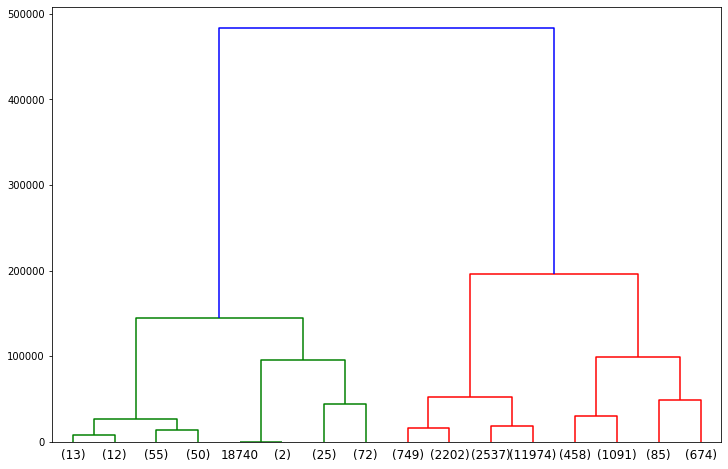

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)    
model = model.fit(X)
    
plot_dendrogram(model, truncate_mode='level', p=3)

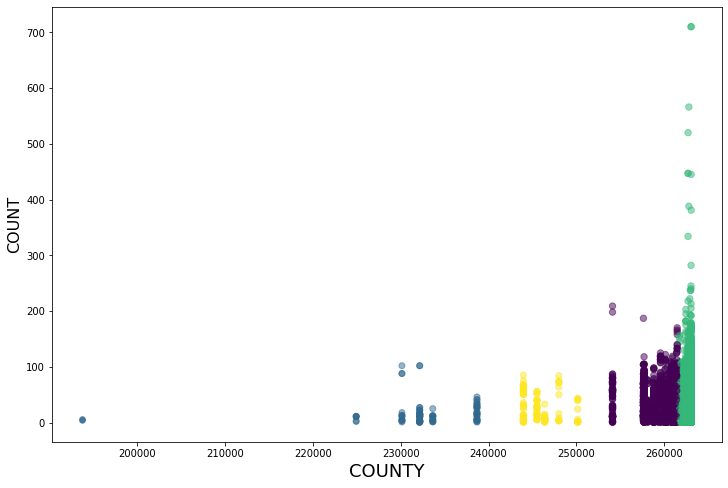

In [ ]:
model = AgglomerativeClustering(n_clusters = 4).fit(X)    
labels = model.labels_

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
area = np.pi * (X[attribute1])*0.00005
plt.scatter(X[attribute1], X[attribute2], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel(attribute1, fontsize=18)
plt.ylabel(attribute2, fontsize=16)

plt.show()

From mathematical co-efficienct as well as the visualizations, it is safe to conclude that for the attributes of 'COUNT' vs 'COUNTY', Hierarchical Clustering method is a much better representative of the patterns present because unlike K-means, Hierarchical clustering does not assume importance of every attribute to be same.

**K-Means Clustering**

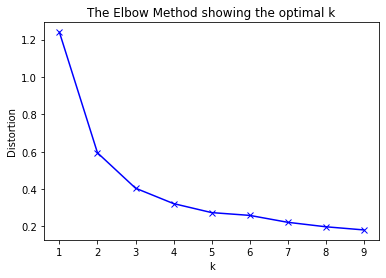

In [ ]:
attribute1 = 'PUBLIC_PRIVATE'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

scaler = StandardScaler()
normalized_dataset = scaler.fit_transform(subset)

X = normalized_dataset # Normalized numpy array, used later in the visualization step

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
for i in range(3, 9):
    model = KMeans(n_clusters=i, n_init=12)
    kmeans = model.fit(X)
    cluster_labels = kmeans.fit_predict(X)
    s = silhouette_score(X, cluster_labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.6069
With  4 clusters, Silhoutte coefficient is  0.6022
With  5 clusters, Silhoutte coefficient is  0.5989
With  6 clusters, Silhoutte coefficient is  0.6009
With  7 clusters, Silhoutte coefficient is  0.6043
With  8 clusters, Silhoutte coefficient is  0.5595


**Optimal Clusters**
No of clusters = 3 is selected using elbow and Silhoutte method above.

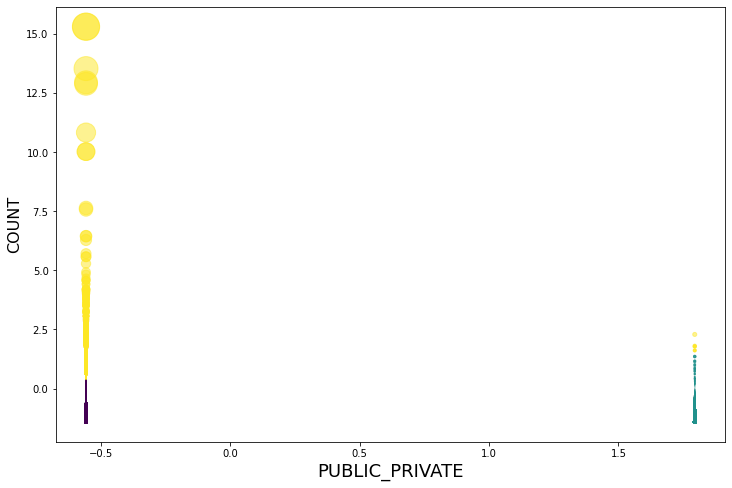

In [ ]:
model = KMeans(n_clusters=3, n_init=12)
kmeans = model.fit(X)
cluster_labels = kmeans.fit_predict(X)
labels = kmeans.labels_

plotClusters(2, attribute1, attribute2, labels)

**Agglomerative Clustering**

In [ ]:
attribute1 = 'PUBLIC_PRIVATE'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
X = subset
subset.head()

,PUBLIC_PRIVATE,COUNT
72113,1,6.0
240143,0,47.0
69078,1,23.0
173997,1,14.0
3021,0,145.0


In [ ]:
for i in range(3, 10):
    clustering = AgglomerativeClustering(n_clusters = i).fit(X)
    labels = clustering.labels_
    s = silhouette_score(X, labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.5422
With  4 clusters, Silhoutte coefficient is  0.544
With  5 clusters, Silhoutte coefficient is  0.5167
With  6 clusters, Silhoutte coefficient is  0.544
With  7 clusters, Silhoutte coefficient is  0.5497
With  8 clusters, Silhoutte coefficient is  0.536
With  9 clusters, Silhoutte coefficient is  0.538


**Optimal Clusters**
No of clusters = 3 have been selected.

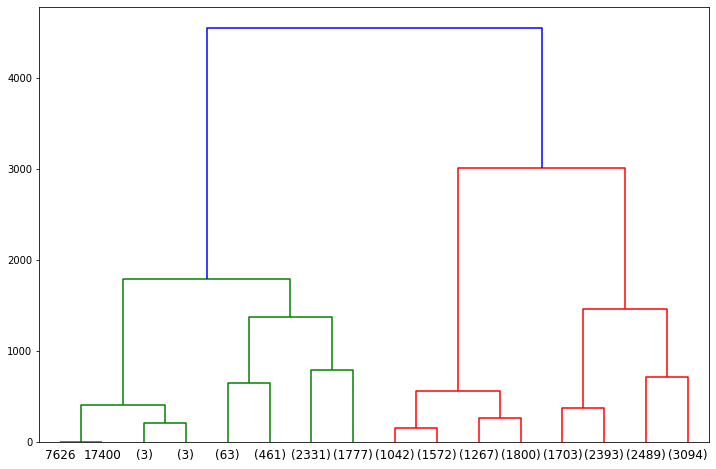

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)    
model = model.fit(X)
    
plot_dendrogram(model, truncate_mode='level', p=3)

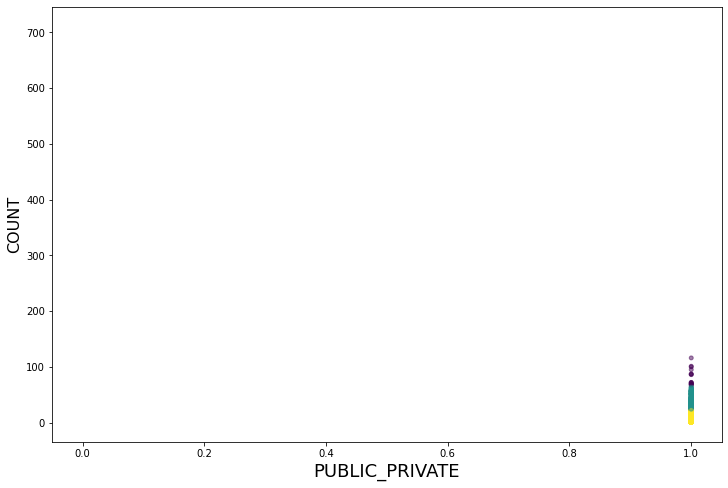

In [ ]:
model = AgglomerativeClustering(n_clusters = 3).fit(X)    
labels = model.labels_

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
area = np.pi * (X[attribute1])*5
plt.scatter(X[attribute1], X[attribute2], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel(attribute1, fontsize=18)
plt.ylabel(attribute2, fontsize=16)

plt.show()

**Conclusion**
From mathematical co-efficienct as well as the visualizations, it is safe to conclude that for the attributes of 'COUNT' vs 'PUBLIC_PRIVATE', K-means clustering with 3 number of clusters is much better representative of the patterns present.

**K-Means Clustering**

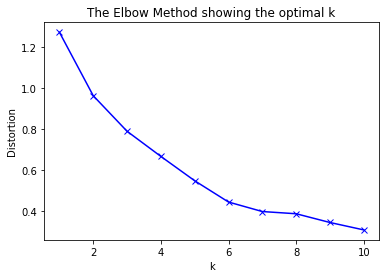

In [ ]:
attribute1 = 'SCHOOL_YEAR'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

scaler = StandardScaler()
normalized_dataset = scaler.fit_transform(subset)

X = normalized_dataset # Normalized numpy array, used later in the visualization step

# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
for i in range(3, 9):
    model = KMeans(n_clusters=i, n_init=12)
    kmeans = model.fit(X)
    cluster_labels = kmeans.fit_predict(X)
    s = silhouette_score(X, cluster_labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.4235
With  4 clusters, Silhoutte coefficient is  0.4275
With  5 clusters, Silhoutte coefficient is  0.4749
With  6 clusters, Silhoutte coefficient is  0.5251
With  7 clusters, Silhoutte coefficient is  0.5532
With  8 clusters, Silhoutte coefficient is  0.5548


**Optimal Clusters**
From Elbow method, no of clusters = 6 are selected.

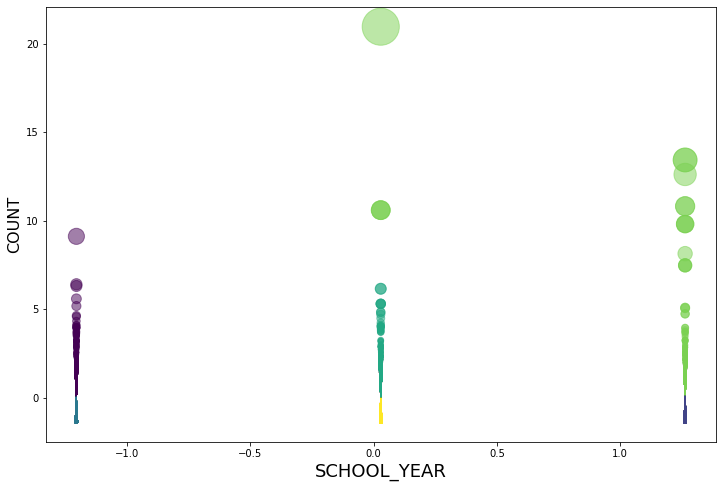

In [ ]:
model = KMeans(n_clusters=6, n_init=12)
kmeans = model.fit(X)
cluster_labels = kmeans.fit_predict(X)
labels = kmeans.labels_

plotClusters(2, attribute1, attribute2, labels)

**Agglomerative Clustering**

In [ ]:
attribute1 = 'SCHOOL_YEAR'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
X = subset
subset.head()

,SCHOOL_YEAR,COUNT
141430,1,24.0
134990,1,19.0
257982,2,15.0
124620,1,62.0
129413,1,103.0


In [ ]:
for i in range(3, 10):
    clustering = AgglomerativeClustering(n_clusters = i).fit(X)
    labels = clustering.labels_
    s = silhouette_score(X, labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.5288
With  4 clusters, Silhoutte coefficient is  0.5295
With  5 clusters, Silhoutte coefficient is  0.5393
With  6 clusters, Silhoutte coefficient is  0.544
With  7 clusters, Silhoutte coefficient is  0.5493
With  8 clusters, Silhoutte coefficient is  0.5189
With  9 clusters, Silhoutte coefficient is  0.4758


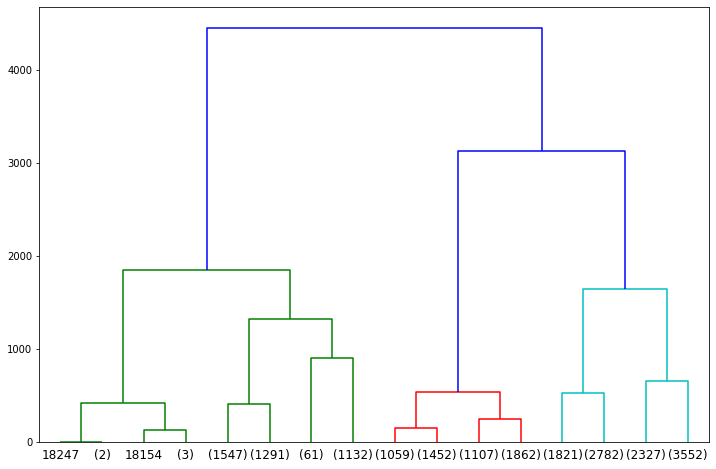

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)    
model = model.fit(X)
    
plot_dendrogram(model, truncate_mode='level', p=3)

**Optimal Clusters**
From highest Silhoutte coefficient, 6 no of clusters are selected.

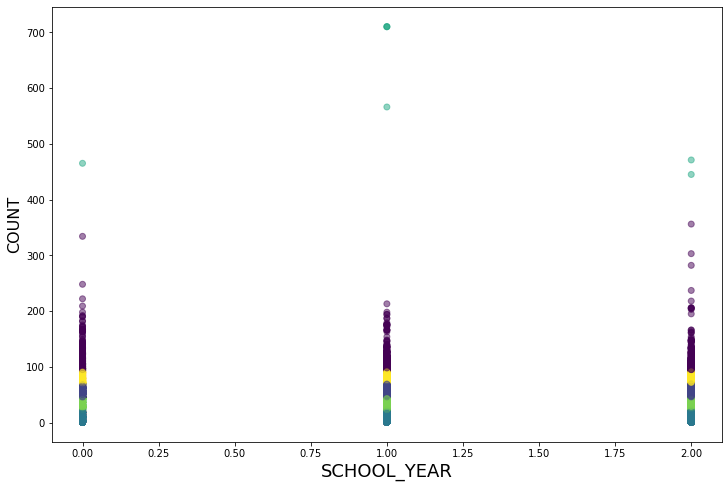

In [ ]:
model = AgglomerativeClustering(n_clusters = 6).fit(X)    
labels = model.labels_

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
area = np.pi * (X[attribute1])*0.005
plt.scatter(X[attribute1], X[attribute2], c=labels.astype(np.float), alpha=0.5)
plt.xlabel(attribute1, fontsize=18)
plt.ylabel(attribute2, fontsize=16)

plt.show()

**Conclusion**
From mathematical co-efficienct as well as the visualizations, it is safe to conclude that for the attributes of  'School Year' vs 'COUNT', roughly same number of immunization is done throughout the years, except for the years 2017-2018, where there are slighly more number of vaccinations.

**K-Means Clustering**

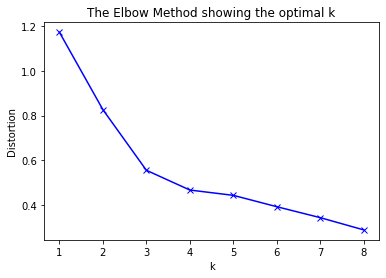

In [ ]:
attribute1 = 'CATEGORY'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

scaler = StandardScaler()
normalized_dataset = scaler.fit_transform(subset)

X = normalized_dataset # Normalized numpy array, used later in the visualization step

# k means determine k
distortions = []
K = range(1,9)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
for i in range(3, 9):
    model = KMeans(n_clusters=i, n_init=12)
    kmeans = model.fit(X)
    cluster_labels = kmeans.fit_predict(X)
    s = silhouette_score(X, cluster_labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.5394
With  4 clusters, Silhoutte coefficient is  0.516
With  5 clusters, Silhoutte coefficient is  0.5166
With  6 clusters, Silhoutte coefficient is  0.548
With  7 clusters, Silhoutte coefficient is  0.5613
With  8 clusters, Silhoutte coefficient is  0.5592


**Optimal Clusters**
From silhoutte method, no of clusters = 7 have been selected.

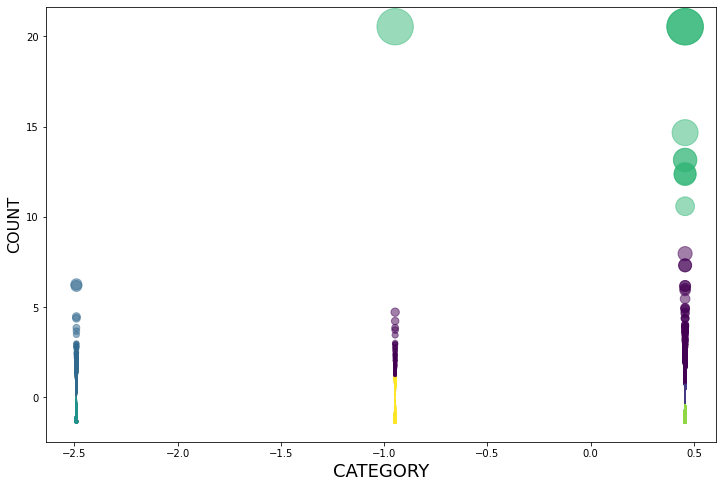

In [ ]:
model = KMeans(n_clusters=7, n_init=12)
kmeans = model.fit(X)
cluster_labels = kmeans.fit_predict(X)
labels = kmeans.labels_

plotClusters(2, attribute1, attribute2, labels)

**Agglomerative Clustering**

In [ ]:
attribute1 = 'CATEGORY'
attribute2 = 'COUNT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
X = subset
subset.head()
for i in range(3, 10):
    clustering = AgglomerativeClustering(n_clusters = i).fit(X)
    labels = clustering.labels_
    s = silhouette_score(X, labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.9996
With  4 clusters, Silhoutte coefficient is  0.6416
With  5 clusters, Silhoutte coefficient is  0.6198
With  6 clusters, Silhoutte coefficient is  0.6254
With  7 clusters, Silhoutte coefficient is  0.5671
With  8 clusters, Silhoutte coefficient is  0.5431
With  9 clusters, Silhoutte coefficient is  0.5336


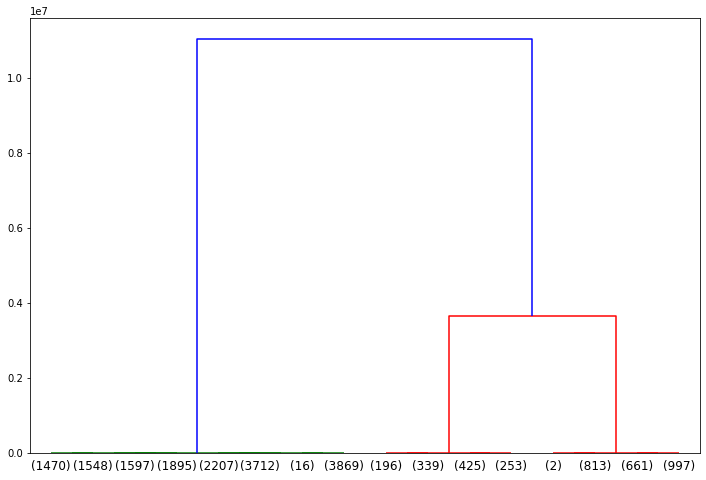

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)    
model = model.fit(X)
    
plot_dendrogram(model, truncate_mode='level', p=3)

**Optimal Clusters**
From highest Silhoutte coefficient, which is  0.9996, 3 no of clusters have been selected.

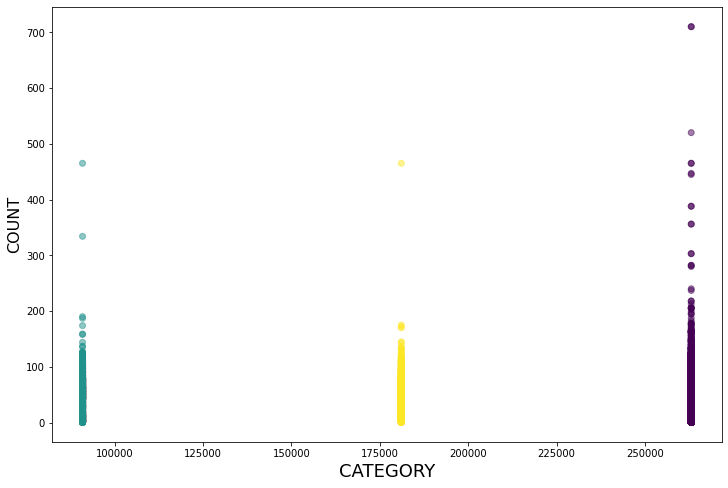

In [ ]:
model = AgglomerativeClustering(n_clusters = 3).fit(X)    
labels = model.labels_

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.scatter(X[attribute1], X[attribute2], c=labels.astype(np.float), alpha=0.5)
plt.xlabel(attribute1, fontsize=18)
plt.ylabel(attribute2, fontsize=16)

plt.show()

**Conclusion**
From mathematical co-efficienct as well as the visualizations, it can be concluded that highest number of immunizations are carried for the categories of HEPM, DTP, PME and MMR.

**K-Means Clustering**

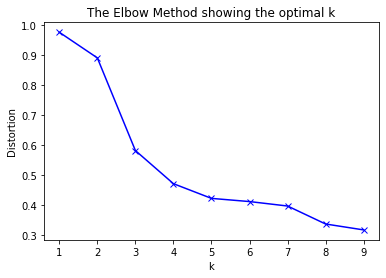

In [ ]:
attribute1 = 'COUNTY'
attribute2 = 'ENROLLMENT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
subset.head()

scaler = StandardScaler()
normalized_dataset = scaler.fit_transform(subset)

X = normalized_dataset # Normalized numpy array, used later in the visualization step

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
for i in range(3, 9):
    model = KMeans(n_clusters=i, n_init=12)
    kmeans = model.fit(X)
    cluster_labels = kmeans.fit_predict(X)
    s = silhouette_score(X, cluster_labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.5097
With  4 clusters, Silhoutte coefficient is  0.4674
With  5 clusters, Silhoutte coefficient is  0.497
With  6 clusters, Silhoutte coefficient is  0.4977
With  7 clusters, Silhoutte coefficient is  0.5001
With  8 clusters, Silhoutte coefficient is  0.4796


**Optimal Clusters**
From Elbow method, no of clusters = 4 have been selected.

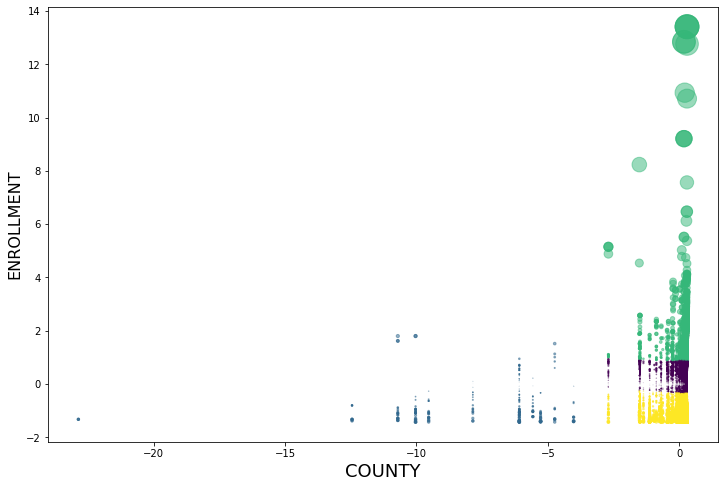

In [ ]:
model = KMeans(n_clusters=4, n_init=12)
kmeans = model.fit(X)
cluster_labels = kmeans.fit_predict(X)
labels = kmeans.labels_

plotClusters(2, attribute1, attribute2, labels)

**Agglomerative Clustering**

In [ ]:
attribute1 = 'COUNTY'
attribute2 = 'ENROLLMENT'

subset = pd.DataFrame()
subset[attribute1] = nonNormalized[attribute1]
subset[attribute2] = nonNormalized[attribute2]

#Pick random subset of the dataset for clustering
subset = subset.sample(n = subset_size)
X = subset
subset.head()
for i in range(3, 10):
    clustering = AgglomerativeClustering(n_clusters = i).fit(X)
    labels = clustering.labels_
    s = silhouette_score(X, labels)
    print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))

With  3 clusters, Silhoutte coefficient is  0.8163
With  4 clusters, Silhoutte coefficient is  0.8176
With  5 clusters, Silhoutte coefficient is  0.7936
With  6 clusters, Silhoutte coefficient is  0.724
With  7 clusters, Silhoutte coefficient is  0.7247
With  8 clusters, Silhoutte coefficient is  0.7299
With  9 clusters, Silhoutte coefficient is  0.7398


**Optimal Clusters**
From highest Silhoutte coefficient, 4 no of clusters are selected.

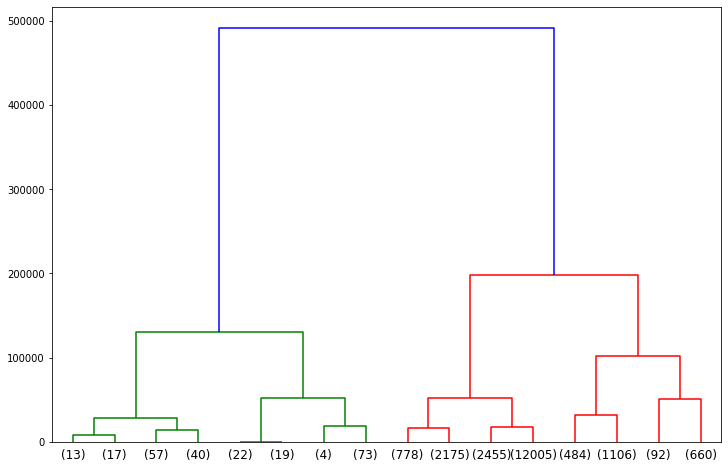

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)    
model = model.fit(X)
    
plot_dendrogram(model, truncate_mode='level', p=3)

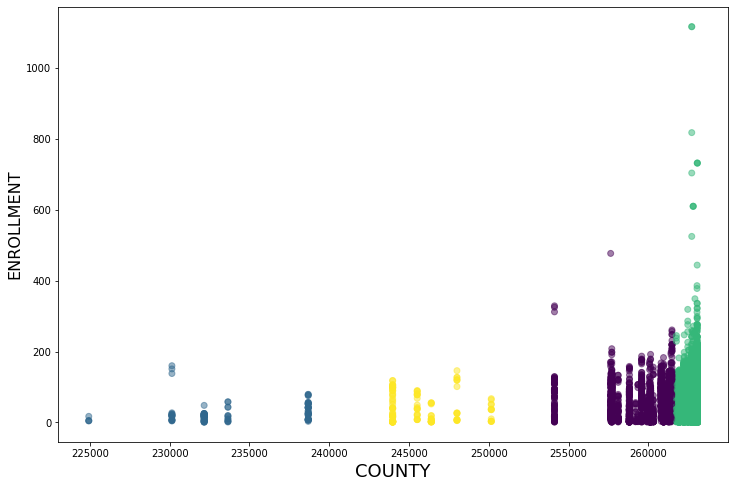

In [ ]:
model = AgglomerativeClustering(n_clusters = 4).fit(X)    
labels = model.labels_

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.scatter(X[attribute1], X[attribute2], c=labels.astype(np.float), alpha=0.5)
plt.xlabel(attribute1, fontsize=18)
plt.ylabel(attribute2, fontsize=16)

plt.show()

**Conclusion**
From mathematical co-efficienct as well as the visualizations, it can be concluded that highest enrollment rates of student are in the counties of ALAMEDA and RIVERSIDE.

**Clustering SCHOOL_NAME VS COUNT against each Category**

With  3 clusters, Silhoutte coefficient is  0.5634
With  4 clusters, Silhoutte coefficient is  0.5693
With  5 clusters, Silhoutte coefficient is  0.5596
With  6 clusters, Silhoutte coefficient is  0.5366


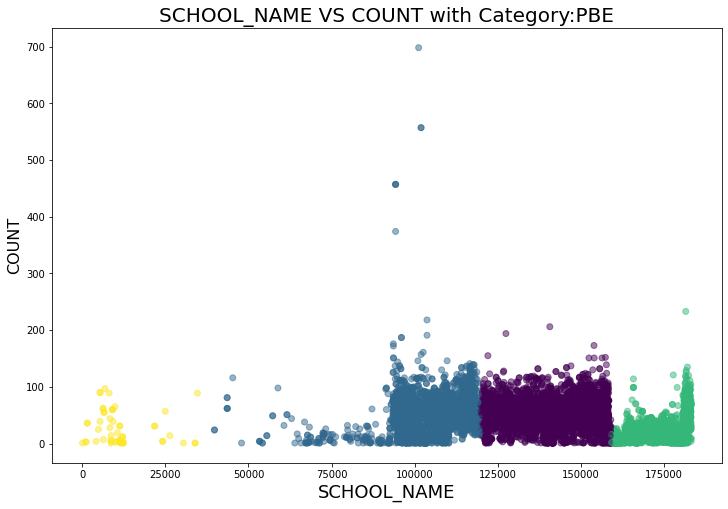

With  3 clusters, Silhoutte coefficient is  0.5263
With  4 clusters, Silhoutte coefficient is  0.5345
With  5 clusters, Silhoutte coefficient is  0.5377
With  6 clusters, Silhoutte coefficient is  0.5622


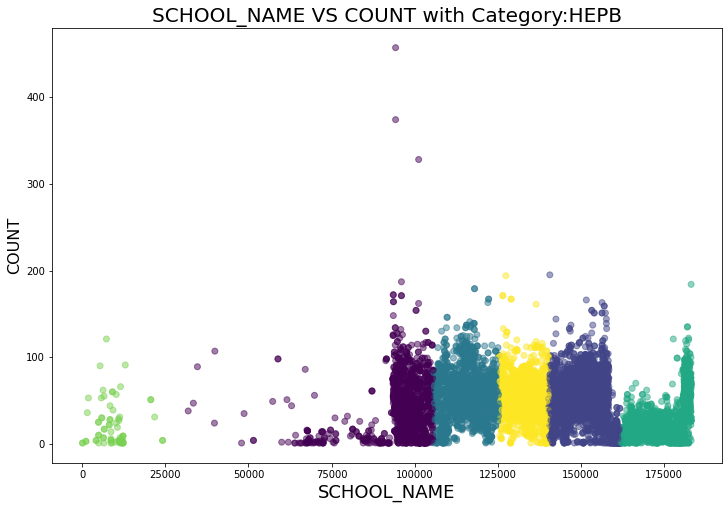

With  3 clusters, Silhoutte coefficient is  0.5385
With  4 clusters, Silhoutte coefficient is  0.5465
With  5 clusters, Silhoutte coefficient is  0.5609
With  6 clusters, Silhoutte coefficient is  0.5576


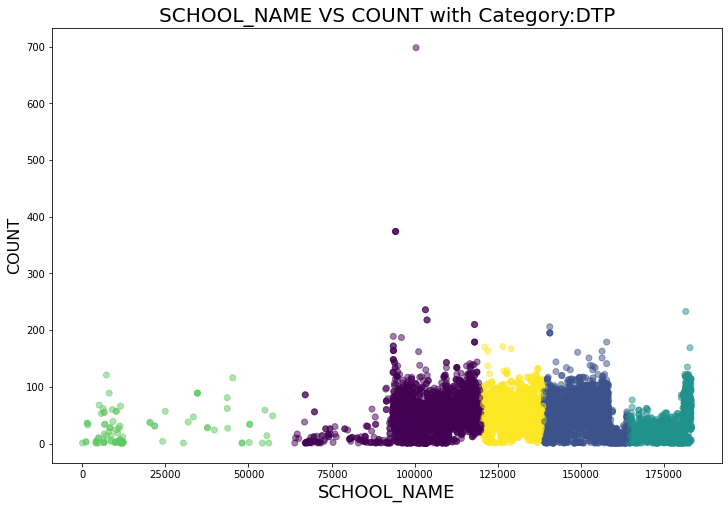

With  3 clusters, Silhoutte coefficient is  0.5705
With  4 clusters, Silhoutte coefficient is  0.5478
With  5 clusters, Silhoutte coefficient is  0.5624
With  6 clusters, Silhoutte coefficient is  0.5081


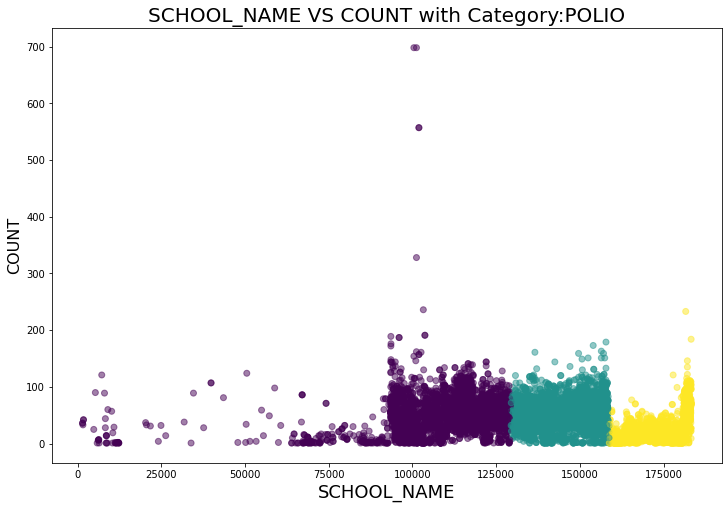

With  3 clusters, Silhoutte coefficient is  0.5515
With  4 clusters, Silhoutte coefficient is  0.5593
With  5 clusters, Silhoutte coefficient is  0.5631
With  6 clusters, Silhoutte coefficient is  0.5529


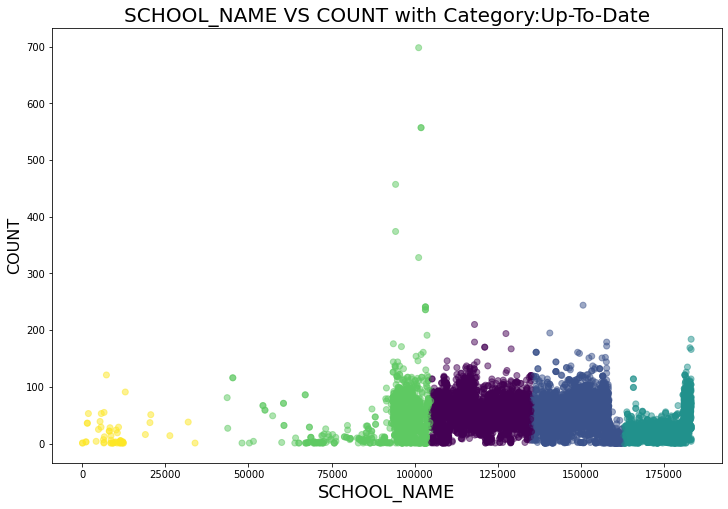

With  3 clusters, Silhoutte coefficient is  0.5381
With  4 clusters, Silhoutte coefficient is  0.5276
With  5 clusters, Silhoutte coefficient is  0.5349
With  6 clusters, Silhoutte coefficient is  0.5435


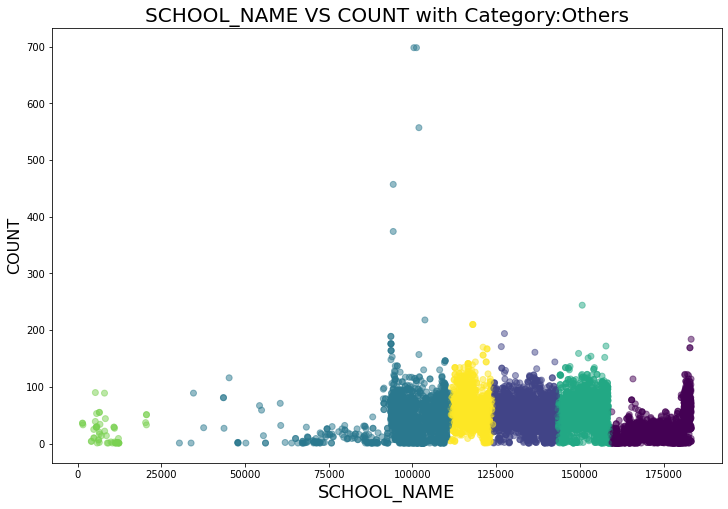

With  3 clusters, Silhoutte coefficient is  0.5695
With  4 clusters, Silhoutte coefficient is  0.5853
With  5 clusters, Silhoutte coefficient is  0.5485
With  6 clusters, Silhoutte coefficient is  0.5432


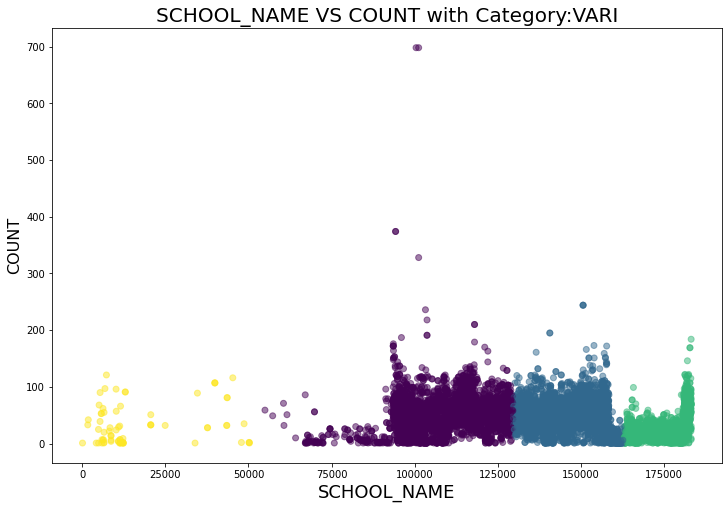

With  3 clusters, Silhoutte coefficient is  0.5339
With  4 clusters, Silhoutte coefficient is  0.5424
With  5 clusters, Silhoutte coefficient is  0.5491
With  6 clusters, Silhoutte coefficient is  0.5568


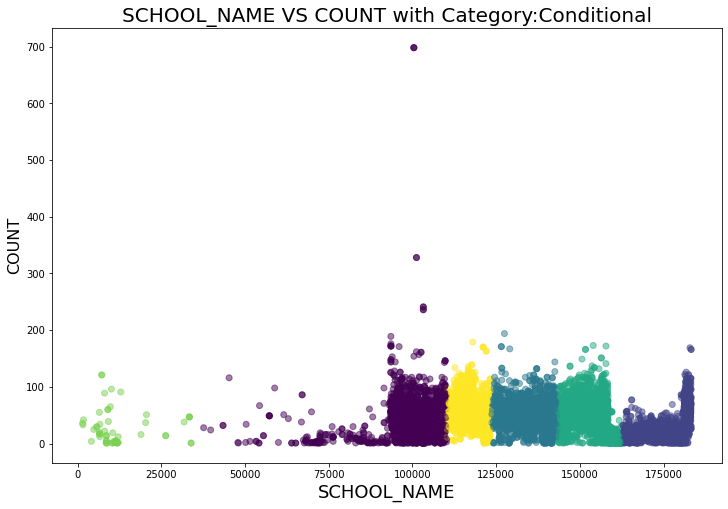

With  3 clusters, Silhoutte coefficient is  0.5614
With  4 clusters, Silhoutte coefficient is  0.5672
With  5 clusters, Silhoutte coefficient is  0.5552
With  6 clusters, Silhoutte coefficient is  0.5286


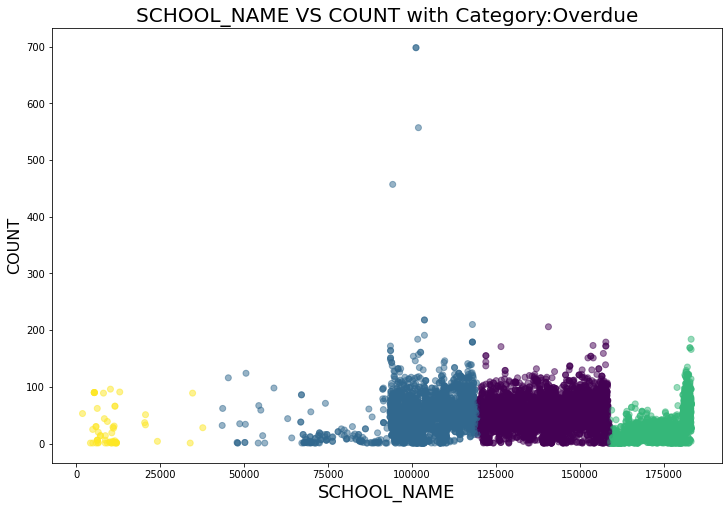

With  3 clusters, Silhoutte coefficient is  0.552
With  4 clusters, Silhoutte coefficient is  0.5213
With  5 clusters, Silhoutte coefficient is  0.5335
With  6 clusters, Silhoutte coefficient is  0.5539


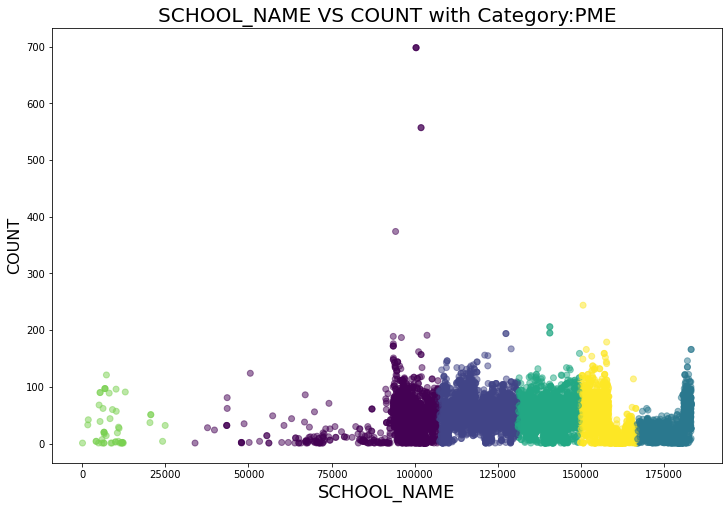

With  3 clusters, Silhoutte coefficient is  0.5318
With  4 clusters, Silhoutte coefficient is  0.5118
With  5 clusters, Silhoutte coefficient is  0.521
With  6 clusters, Silhoutte coefficient is  0.5488


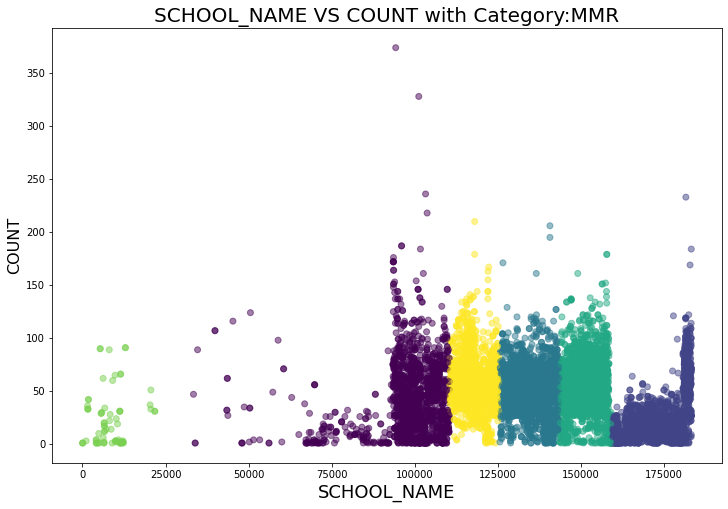

With  3 clusters, Silhoutte coefficient is  0.5172
With  4 clusters, Silhoutte coefficient is  0.5641
With  5 clusters, Silhoutte coefficient is  0.5788
With  6 clusters, Silhoutte coefficient is  0.5383


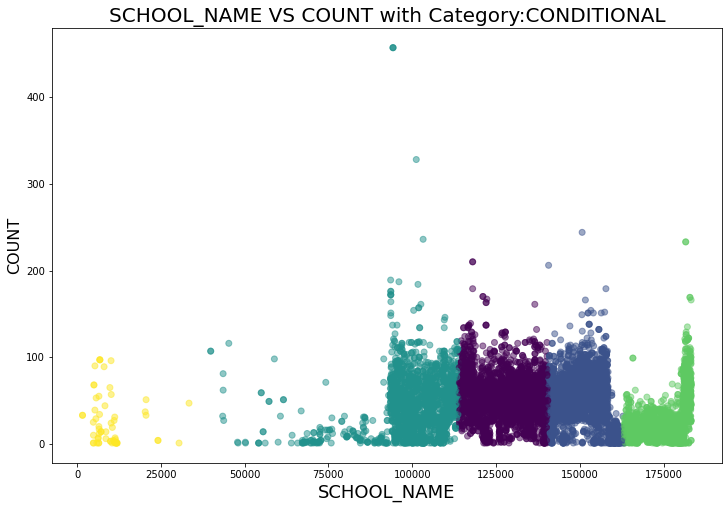

With  3 clusters, Silhoutte coefficient is  0.5306
With  4 clusters, Silhoutte coefficient is  0.5005
With  5 clusters, Silhoutte coefficient is  0.5043
With  6 clusters, Silhoutte coefficient is  0.4949


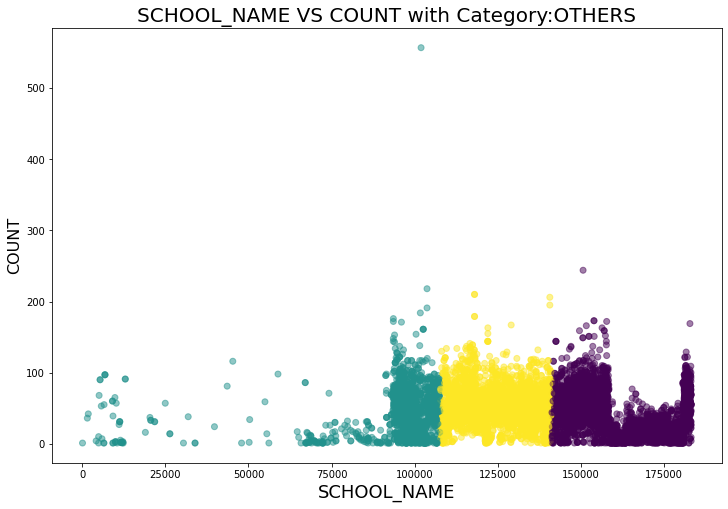

With  3 clusters, Silhoutte coefficient is  0.5593
With  4 clusters, Silhoutte coefficient is  0.566
With  5 clusters, Silhoutte coefficient is  0.5623
With  6 clusters, Silhoutte coefficient is  0.5215


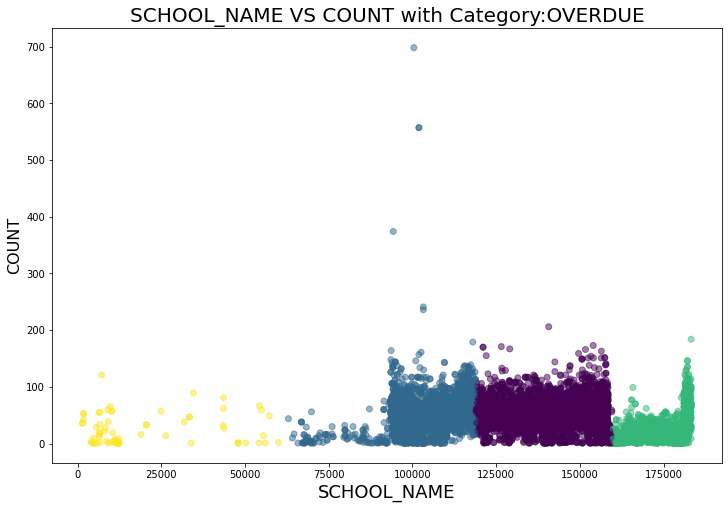

With  3 clusters, Silhoutte coefficient is  0.503
With  4 clusters, Silhoutte coefficient is  0.5076
With  5 clusters, Silhoutte coefficient is  0.5091
With  6 clusters, Silhoutte coefficient is  0.5196


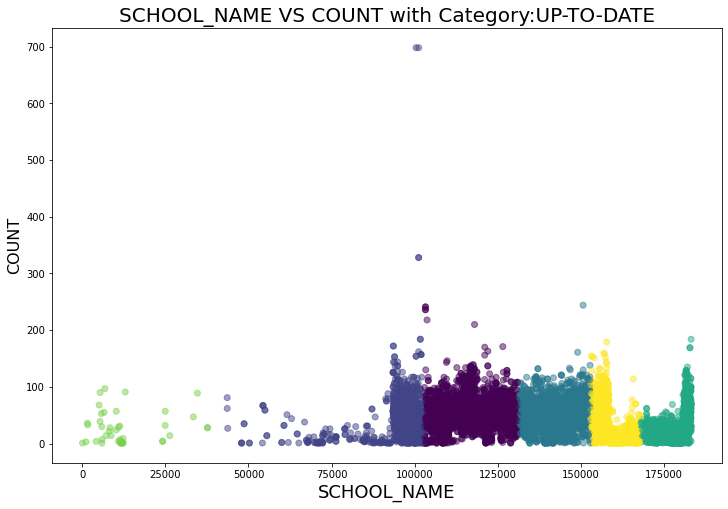

With  3 clusters, Silhoutte coefficient is  0.5273
With  4 clusters, Silhoutte coefficient is  0.5463
With  5 clusters, Silhoutte coefficient is  0.5606
With  6 clusters, Silhoutte coefficient is  0.5421


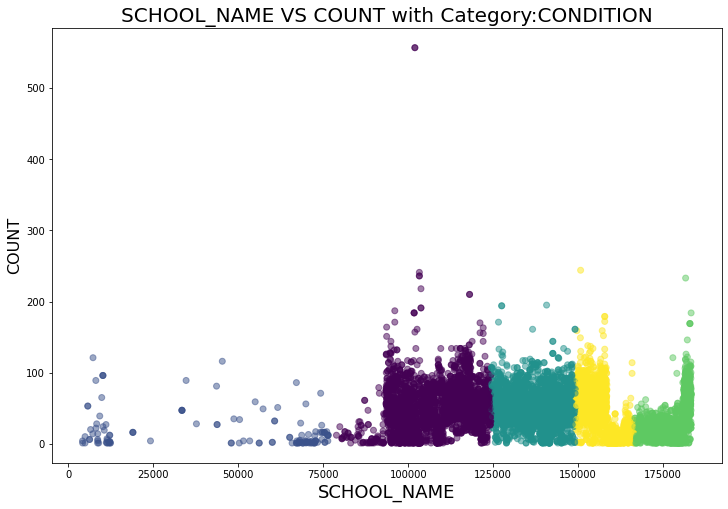

In [ ]:
attribute1 = 'SCHOOL_NAME'
attribute2 = 'COUNT'

subset_size = 10000

for key in category_dict:
    df = nonNormalized[nonNormalized.CATEGORY==category_dict[key]]

    subset = pd.DataFrame()
    subset[attribute1] = df[attribute1]
    subset[attribute2] = df[attribute2]

    subset = pd.DataFrame()
    subset[attribute1] = nonNormalized[attribute1]
    subset[attribute2] = nonNormalized[attribute2]

    #Pick random subset of the dataset for clustering
    subset = subset.sample(n = subset_size)
    X = subset

    cluster = 0
    maxScore = 0
    for i in range(3, 7):
        clustering = AgglomerativeClustering(n_clusters = i).fit(X)
        labels = clustering.labels_
        s = silhouette_score(X, labels)
        print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))
        if(s > maxScore):
            maxScore = s
            cluster = i
    
    model = AgglomerativeClustering(n_clusters = cluster).fit(X)    
    labels = model.labels_

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    plt.scatter(X[attribute1], X[attribute2], c=labels.astype(np.float), alpha=0.5)
    plt.xlabel(attribute1, fontsize=18)
    plt.ylabel(attribute2, fontsize=16)
    plt.title(attribute1 + " VS " + attribute2 + " with Category:" + key, fontsize=20)
    plt.show()



**Clustering CITY VS COUNT against each Category**

With  3 clusters, Silhoutte coefficient is  0.737
With  4 clusters, Silhoutte coefficient is  0.7443
With  5 clusters, Silhoutte coefficient is  0.7017
With  6 clusters, Silhoutte coefficient is  0.7094


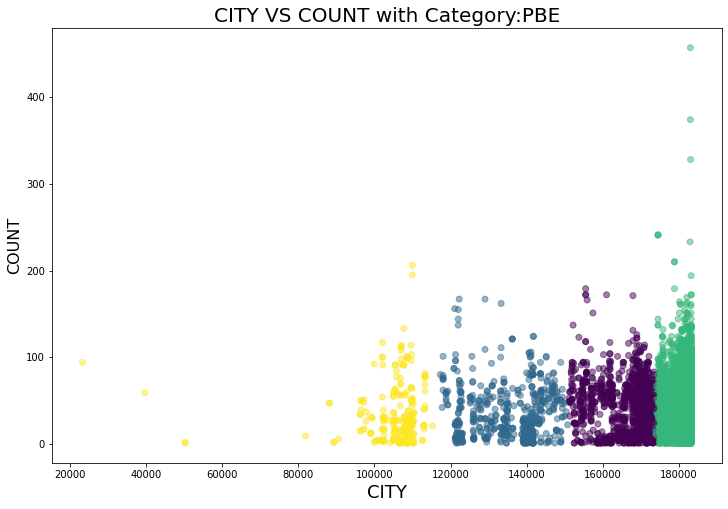

With  3 clusters, Silhoutte coefficient is  0.7319
With  4 clusters, Silhoutte coefficient is  0.7405
With  5 clusters, Silhoutte coefficient is  0.7416
With  6 clusters, Silhoutte coefficient is  0.5894


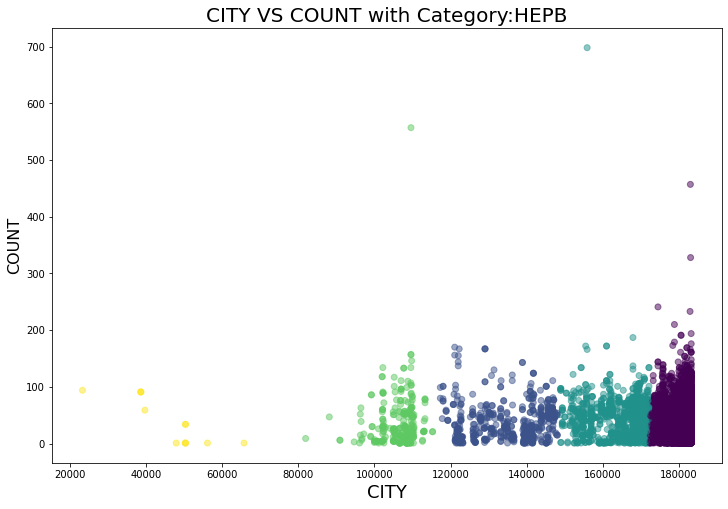

With  3 clusters, Silhoutte coefficient is  0.7981
With  4 clusters, Silhoutte coefficient is  0.7148
With  5 clusters, Silhoutte coefficient is  0.7195
With  6 clusters, Silhoutte coefficient is  0.6082


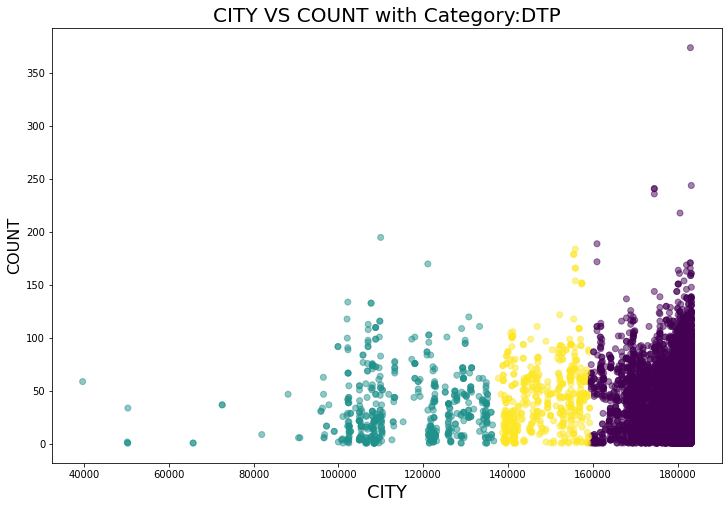

With  3 clusters, Silhoutte coefficient is  0.813
With  4 clusters, Silhoutte coefficient is  0.7547
With  5 clusters, Silhoutte coefficient is  0.6479
With  6 clusters, Silhoutte coefficient is  0.6522


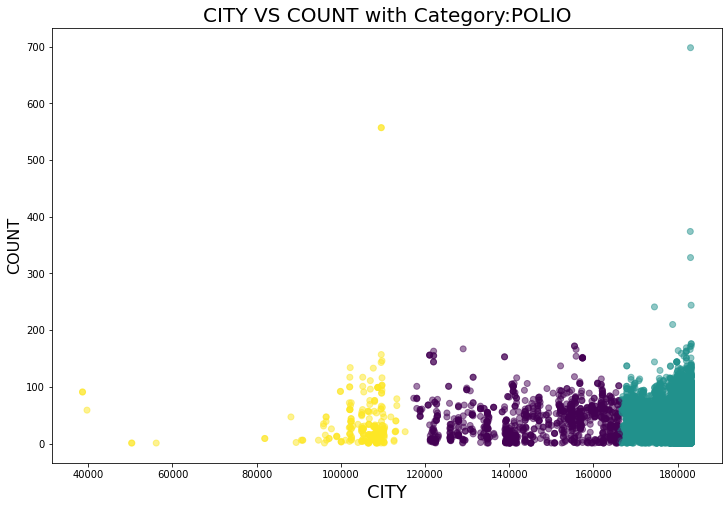

With  3 clusters, Silhoutte coefficient is  0.6285
With  4 clusters, Silhoutte coefficient is  0.6319
With  5 clusters, Silhoutte coefficient is  0.6499
With  6 clusters, Silhoutte coefficient is  0.6584


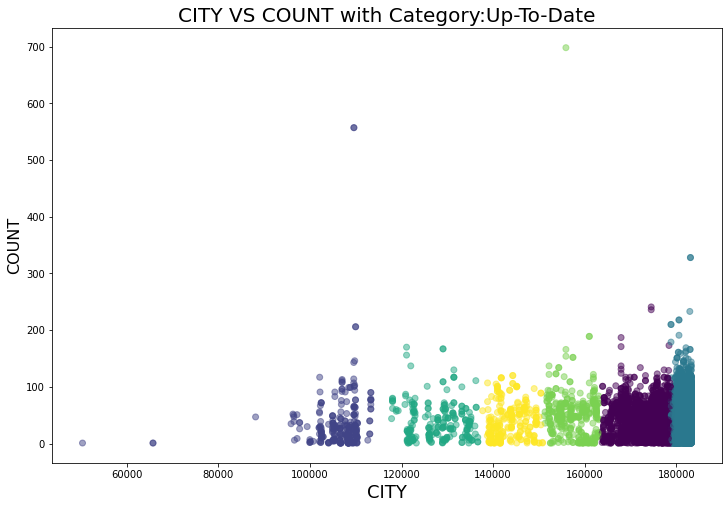

With  3 clusters, Silhoutte coefficient is  0.7361
With  4 clusters, Silhoutte coefficient is  0.7424
With  5 clusters, Silhoutte coefficient is  0.6844
With  6 clusters, Silhoutte coefficient is  0.5783


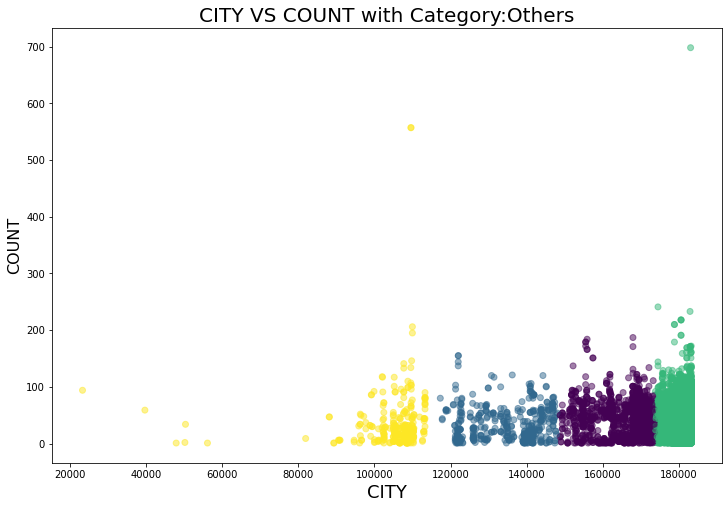

With  3 clusters, Silhoutte coefficient is  0.7279
With  4 clusters, Silhoutte coefficient is  0.7346
With  5 clusters, Silhoutte coefficient is  0.6771
With  6 clusters, Silhoutte coefficient is  0.6838


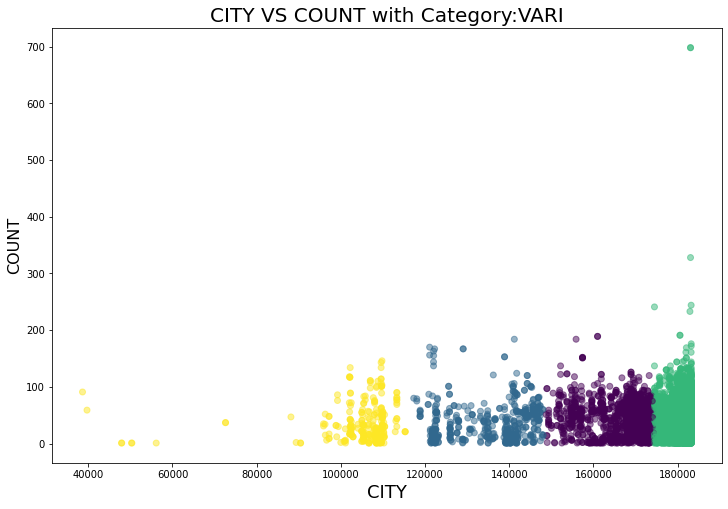

With  3 clusters, Silhoutte coefficient is  0.7348
With  4 clusters, Silhoutte coefficient is  0.7383
With  5 clusters, Silhoutte coefficient is  0.6767
With  6 clusters, Silhoutte coefficient is  0.6847


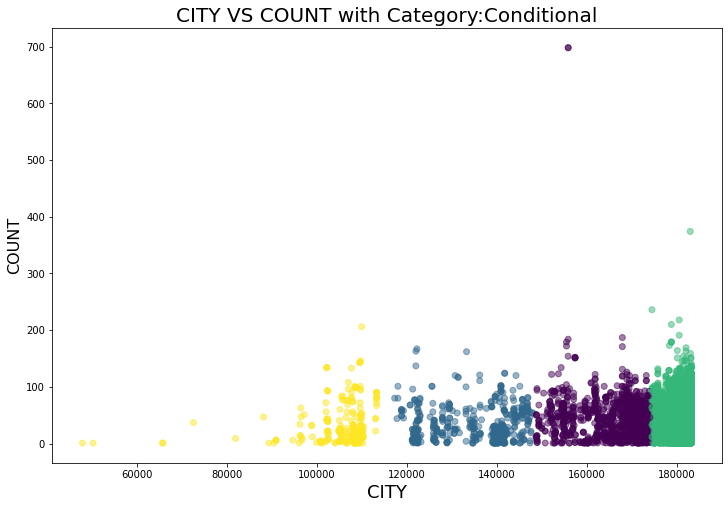

With  3 clusters, Silhoutte coefficient is  0.7315
With  4 clusters, Silhoutte coefficient is  0.7388
With  5 clusters, Silhoutte coefficient is  0.6982
With  6 clusters, Silhoutte coefficient is  0.6996


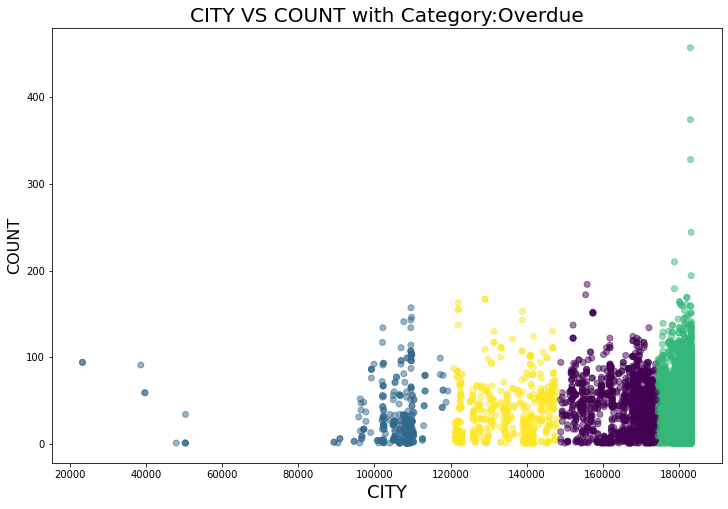

With  3 clusters, Silhoutte coefficient is  0.7296
With  4 clusters, Silhoutte coefficient is  0.7377
With  5 clusters, Silhoutte coefficient is  0.6828
With  6 clusters, Silhoutte coefficient is  0.6836


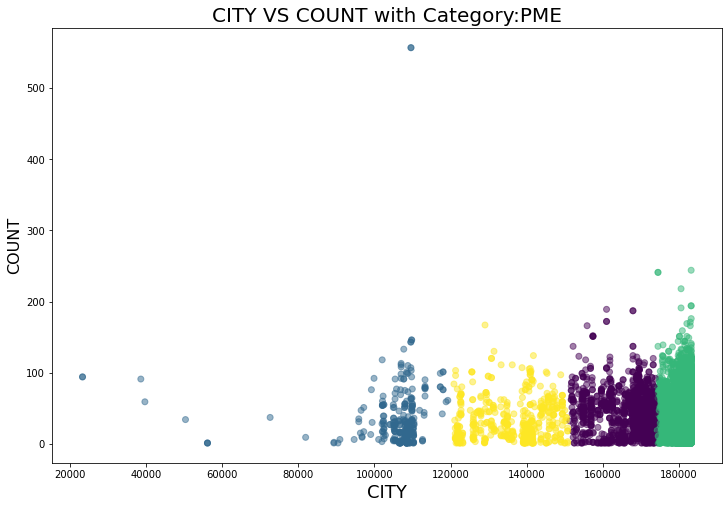

With  3 clusters, Silhoutte coefficient is  0.7319
With  4 clusters, Silhoutte coefficient is  0.7403
With  5 clusters, Silhoutte coefficient is  0.6967
With  6 clusters, Silhoutte coefficient is  0.6184


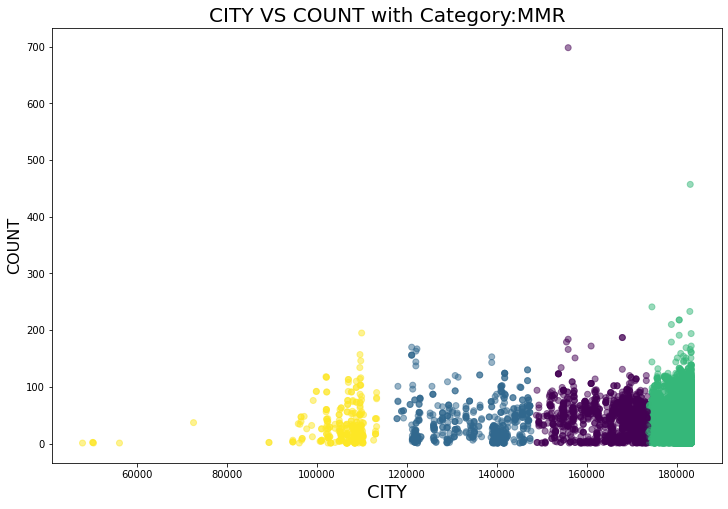

With  3 clusters, Silhoutte coefficient is  0.6352
With  4 clusters, Silhoutte coefficient is  0.6381
With  5 clusters, Silhoutte coefficient is  0.6584
With  6 clusters, Silhoutte coefficient is  0.6645


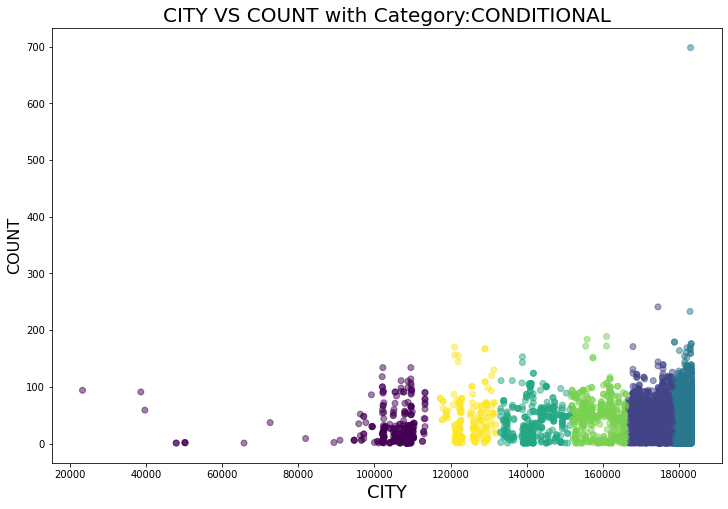

With  3 clusters, Silhoutte coefficient is  0.6763
With  4 clusters, Silhoutte coefficient is  0.6794
With  5 clusters, Silhoutte coefficient is  0.6838
With  6 clusters, Silhoutte coefficient is  0.6885


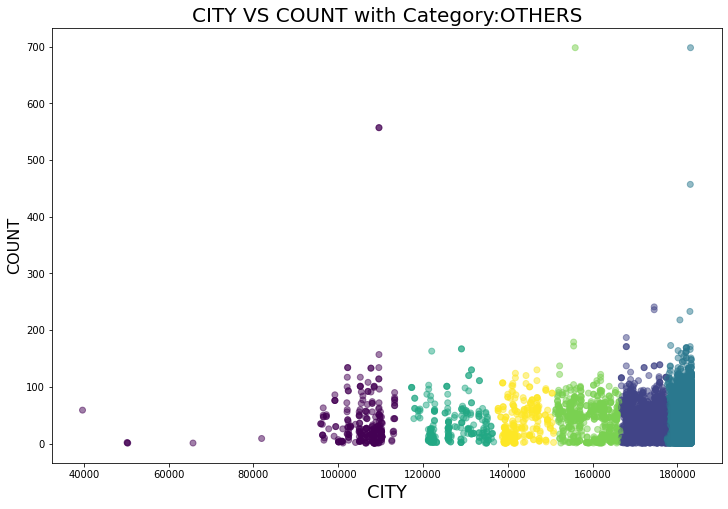

With  3 clusters, Silhoutte coefficient is  0.8071
With  4 clusters, Silhoutte coefficient is  0.7494
With  5 clusters, Silhoutte coefficient is  0.6462
With  6 clusters, Silhoutte coefficient is  0.6475


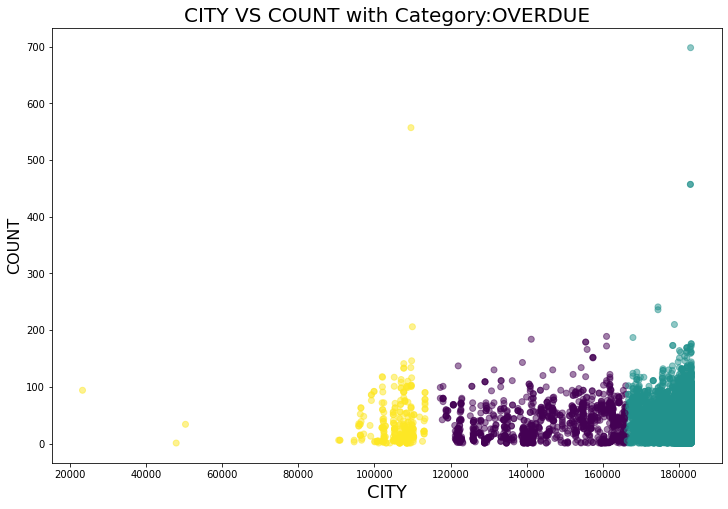

With  3 clusters, Silhoutte coefficient is  0.7406
With  4 clusters, Silhoutte coefficient is  0.7535
With  5 clusters, Silhoutte coefficient is  0.642
With  6 clusters, Silhoutte coefficient is  0.6446


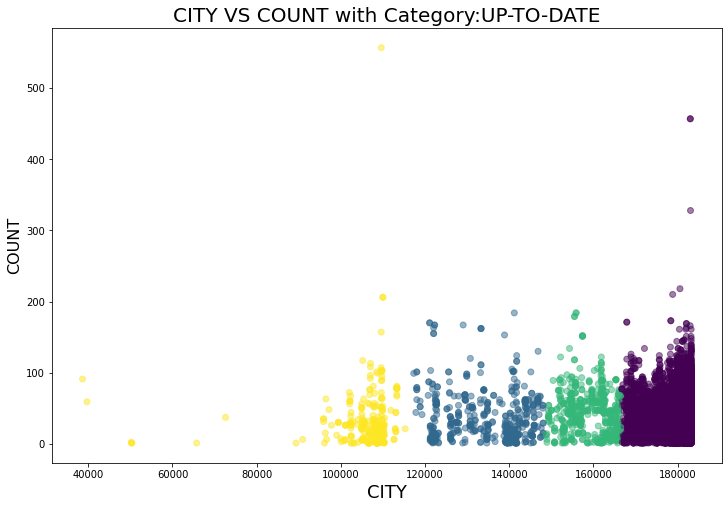

With  3 clusters, Silhoutte coefficient is  0.6771
With  4 clusters, Silhoutte coefficient is  0.6803
With  5 clusters, Silhoutte coefficient is  0.684
With  6 clusters, Silhoutte coefficient is  0.6901


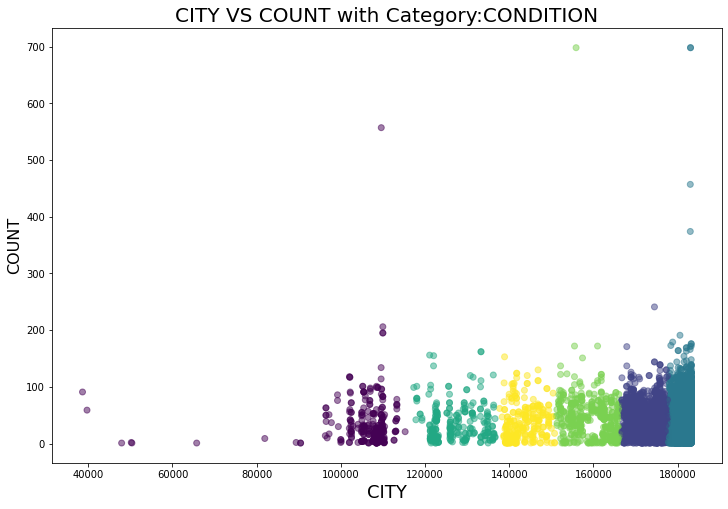

In [ ]:
attribute1 = 'CITY'
attribute2 = 'COUNT'

for key in category_dict:
    df = nonNormalized[nonNormalized.COUNTY==category_dict[key]]

    subset = pd.DataFrame()
    subset[attribute1] = df[attribute1]
    subset[attribute2] = df[attribute2]
    
    #Agglomerative Clustering

    subset = pd.DataFrame()
    subset[attribute1] = nonNormalized[attribute1]
    subset[attribute2] = nonNormalized[attribute2]

    #Pick random subset of the dataset for clustering
    subset = subset.sample(n = subset_size)
    X = subset
    
    cluster = 0
    maxScore = 0
    for i in range(3, 7):
        clustering = AgglomerativeClustering(n_clusters = i).fit(X)
        labels = clustering.labels_
        s = silhouette_score(X, labels)
        print('With ', i, 'clusters, Silhoutte coefficient is ', round(s, 4))
        if(s > maxScore):
            maxScore = s
            cluster = i

    model = AgglomerativeClustering(n_clusters = cluster).fit(X)    
    labels = model.labels_

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    plt.scatter(X[attribute1], X[attribute2], c=labels.astype(np.float), alpha=0.5)
    plt.xlabel(attribute1, fontsize=18)
    plt.ylabel(attribute2, fontsize=16)
    plt.title(attribute1 + " VS " + attribute2 + " with Category:" + key, fontsize=20)
    plt.show()